In [832]:
#Импорт необходимых библиотек

#Для работы с данными
import pandas as pd
import numpy as np
#Для кодирования данных
import category_encoders as ce

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn import metrics
import optuna
import xgboost as xgb
import catboost

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')


#Ядро случайности
random_seed = 42

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# **<center>Предсказание цен на аренду недвижимости в Москве</center>**

## Описание задачи:

Необходимо реализовать сервис, который будет помогать выставлять ценник на аренду квартиры в Москве. Сервис будет представлен в виде Telegram-бота. Обучаться модель будет на данных, взятых с базы объявлений недвижимости - Циан, вы можете взять готовые данные или собрать их самостоятельно, используя парсер из репозитория.

## Знакомство с данными и их очистка

Считываем наши данные.

In [ ]:
data = pd.read_csv('./data/cyan_data.csv')
print(f'Размер таблицы: {data.shape}')
data.head()

Размер таблицы: (1500, 19)


,Дата создания объявления,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Адрес,Округ,"Ближайшее метро, мин.","Ближайший вокзал, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Год постройки здания,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка
0,2024-11-12T20:27:58.11,20,23,75.0,45.5,10.0,3,True,"Москва, ул. Берзарина, д. 30",СЗАО,4,-1,168800,0,True,-1,1,1,underground
1,2024-11-15T20:09:15.127,3,10,173.0,130.0,24.0,3,True,"Москва, Фадеева ул., 4A",ЦАО,8,-1,950000,0,True,-1,0,1,underground
2,2024-11-22T18:54:53.14,23,23,42.0,18.0,9.0,1,True,"Москва, Внуковское п, Внуково п, Анны Ахматово...",НАО (Новомосковский),2,-1,60000,0,True,-1,0,3,-1
3,2024-10-16T16:24:47.157,8,10,125.0,72.0,16.0,3,True,"Москва, 2-ая Тверская-Ямская ул., 26",ЦАО,3,15,400000,0,True,-1,0,1,underground
4,2024-10-31T16:57:12.693,45,75,120.0,-1.0,-1.0,3,True,"Россия, Москва, 1-й Красногвардейский проезд, 15",ЦАО,3,10,570000,0,True,2013,2,4,underground


Удаляем признаки, которые не несут полезной информации.

In [ ]:
data = data.drop('Дата создания объявления', axis=1)
data.head()

,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Адрес,Округ,"Ближайшее метро, мин.","Ближайший вокзал, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Год постройки здания,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка
0,20,23,75.0,45.5,10.0,3,True,"Москва, ул. Берзарина, д. 30",СЗАО,4,-1,168800,0,True,-1,1,1,underground
1,3,10,173.0,130.0,24.0,3,True,"Москва, Фадеева ул., 4A",ЦАО,8,-1,950000,0,True,-1,0,1,underground
2,23,23,42.0,18.0,9.0,1,True,"Москва, Внуковское п, Внуково п, Анны Ахматово...",НАО (Новомосковский),2,-1,60000,0,True,-1,0,3,-1
3,8,10,125.0,72.0,16.0,3,True,"Москва, 2-ая Тверская-Ямская ул., 26",ЦАО,3,15,400000,0,True,-1,0,1,underground
4,45,75,120.0,-1.0,-1.0,3,True,"Россия, Москва, 1-й Красногвардейский проезд, 15",ЦАО,3,10,570000,0,True,2013,2,4,underground


### **Описание признаков**

|Признак | Описание|Тип данных|
|---|---|---|
|Этаж|Номер этажа, на котором находится квартира|Категориальный|
|Кол-во этажей|Кол-во этажей в здании|Категориальный|
|Площадь|Общая площадь квартиры|Числовой|
|Жилая площадь|Жилая площадь в квартире|Числовой|
|Площадь кухни|Площадь кухни в квартире|Числовой|
|Кол-во комнат|Кол-во комнат в квартире|Категориальный|
|Наличие мебели|Показатель того, есть ли в квартире мебель или нет|Категориальный|
|Адрес|Адрес, по которому находится квартира|Категориальный|
|Округ|Округ, в котором находится квартира|Категориальный|
|Ближайшее метро, мин.|Время, которое надо затратить, чтобы дойти до метро пешком|Числовой|
|Ближайший вокзал, мин.|Время, которое надо затратить, чтобы дойти до вокзала пешком|Числовой|
|Стоимость, мес.|Стоимость квартиры в месяц, целевая переменная|Числовой|
|Кол-во балконов|Сколько балконов находится в квартире|Категориальный|
|Продажа от агента|Продает агент или собственник|Категориальный|
|Год постройки здания|Год, в котором построили здание|Числовой|
|Кол-во грузовых лифтов|Кол-во грузовых лифтов в здании, где находится квартире|Категориальный|
|Кол-во пассажирских лифтов|Кол-во пассажирских лифтов в здании, где находится квартире|Категориальный|
|Парковка|Тип парковки|Категориальный|

В данных пропуски представлены значением -1, давайте исправим их на значения None для удобства.

In [ ]:
for column in data.columns:
    data[column] = data[column].apply(lambda x: None if x == -1 or x == '-1' else x) 

Посмотрим на основную информацию о данных.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Этаж                        1500 non-null   int64  
 1   Кол-во этажей               1500 non-null   int64  
 2   Площадь                     1500 non-null   float64
 3   Жилая площадь               1094 non-null   float64
 4   Площадь кухни               1214 non-null   float64
 5   Кол-во комнат               1500 non-null   int64  
 6   Наличие мебели              1500 non-null   bool   
 7   Адрес                       1500 non-null   object 
 8   Округ                       1500 non-null   object 
 9   Ближайшее метро, мин.       1498 non-null   float64
 10  Ближайший вокзал, мин.      514 non-null    float64
 11  Стоимость, мес.             1500 non-null   int64  
 12  Кол-во балконов             1500 non-null   int64  
 13  Продажа от агента           1500 

Проверим данные на дубликаты.

In [ ]:
data.duplicated().sum()

np.int64(100)

В данных присутствует 100 дубликатов, удалим их.

In [ ]:
data = data.drop_duplicates()
f'Размер таблицы: {data.shape}'

'Размер таблицы: (1400, 18)'

### **Заполнение пропусков**

Заметим, что в наших данных присутствуют пропуски, удаляем те признаки, в которых пропусков более 70 процентов.

In [ ]:
min_clean_count = 0.7 * data.shape[0]
data = data.dropna(thresh=min_clean_count, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Этаж                        1400 non-null   int64  
 1   Кол-во этажей               1400 non-null   int64  
 2   Площадь                     1400 non-null   float64
 3   Жилая площадь               1010 non-null   float64
 4   Площадь кухни               1128 non-null   float64
 5   Кол-во комнат               1400 non-null   int64  
 6   Наличие мебели              1400 non-null   bool   
 7   Адрес                       1400 non-null   object 
 8   Округ                       1400 non-null   object 
 9   Ближайшее метро, мин.       1398 non-null   float64
 10  Стоимость, мес.             1400 non-null   int64  
 11  Кол-во балконов             1400 non-null   int64  
 12  Продажа от агента           1400 non-null   bool   
 13  Кол-во грузовых лифтов      1400 non-n

Остается еще четыре признака с пропусками: "Жилая площадь", "Площадь кухни", "Ближайшее метро, мин" и "Парковка". Давайте заполним пропуски для каждого из них.

**"Жилая площадь"** - можем предположить, что если в признаке присутствует пропуск, то его жилая площадь равна площади квартиры. Тогда заполним пропуски соответствующим значением, из признака "Площадь".

Перед этим посмотрим на распределение признака:

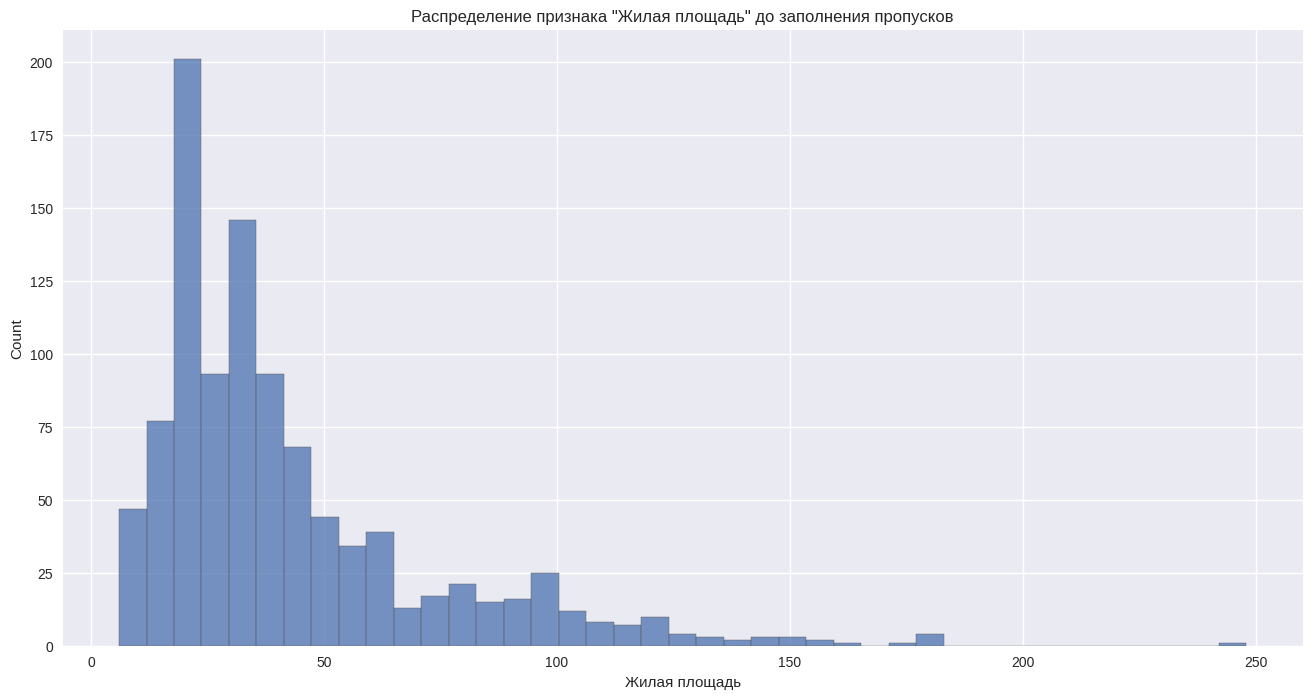

In [ ]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Жилая площадь', ax=ax)
ax.set_title('Распределение признака "Жилая площадь" до заполнения пропусков');

Заполняем пропуски.

In [ ]:
for index, row in data.iterrows():
    if np.isnan(row['Жилая площадь']):
        data.loc[index,'Жилая площадь'] = row['Площадь']
        
data['Жилая площадь'].isnull().sum()

np.int64(0)

Теперь снова посмотрим на распределение.

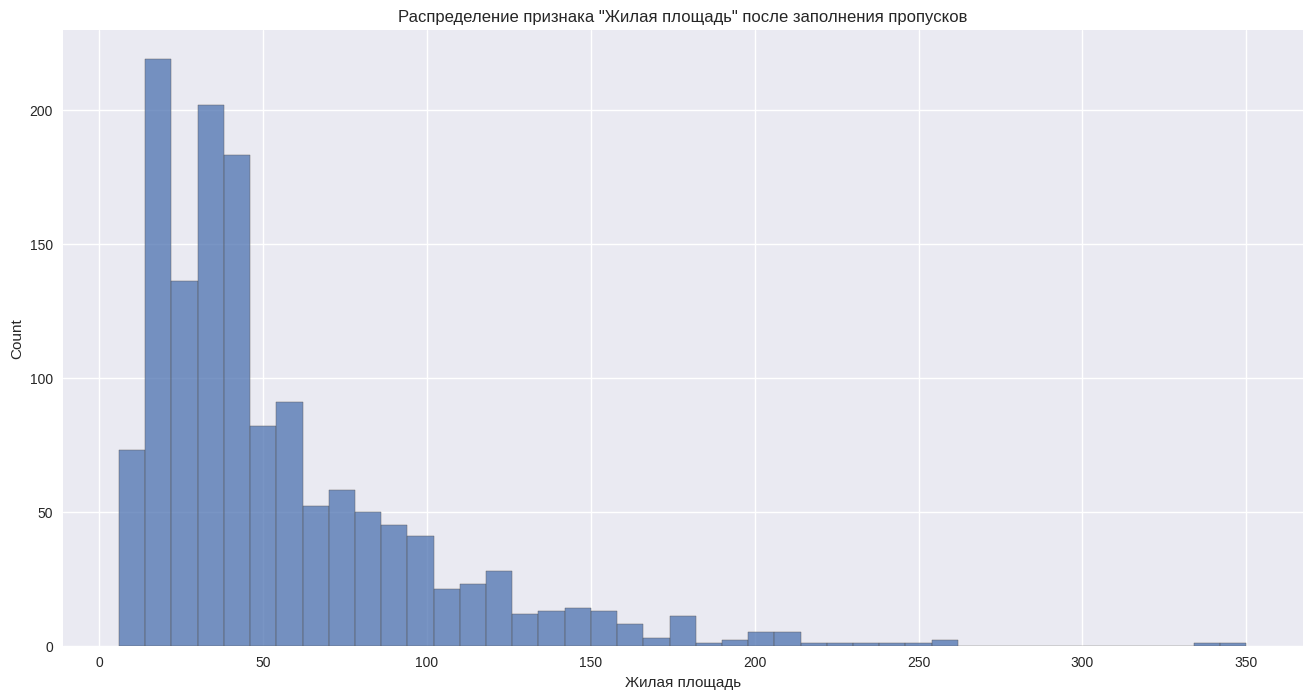

In [ ]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Жилая площадь', ax=ax)
ax.set_title('Распределение признака "Жилая площадь" после заполнения пропусков');

Можем наблюдать, что общая картина распределения осталась прежней.

**"Площадь кухни"** - все немного сложнее, мы не можем просто взять какую-то центральную величену, например, медиану, потому что тогда может получиться такое, что площадь кухни будет больше или равна площади квартиры, что противоречит какой-либо логике. Давайте поступим следующим образом: будем считать, если в признаке пропуск, то площадь кухни равна *Площадь / Кол-во комнат*.

Также посмотрим на распределение:

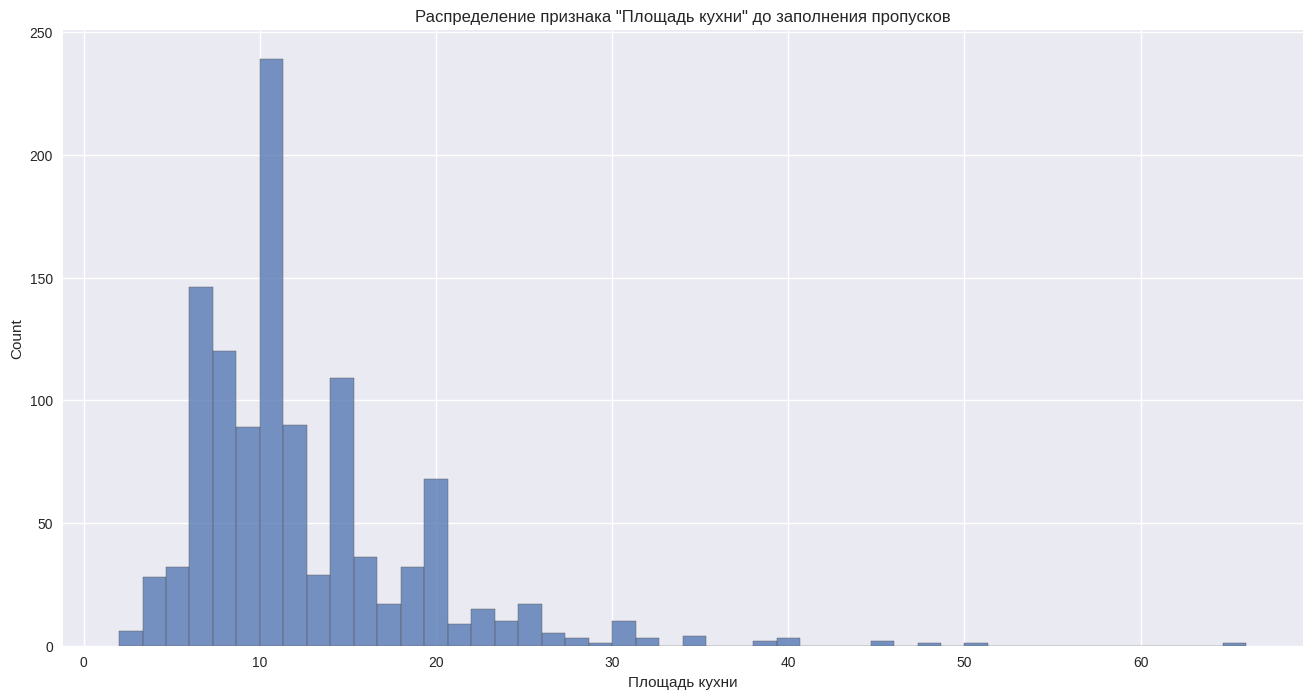

In [ ]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Площадь кухни', ax=ax)
ax.set_title('Распределение признака "Площадь кухни" до заполнения пропусков');

Избавляемся от пропусков.

In [ ]:
for index, row in data.iterrows():
    if np.isnan(row['Площадь кухни']):
        data.at[index,'Площадь кухни'] = row['Площадь'] / row['Кол-во комнат']
        
data['Площадь кухни'].isnull().sum()

np.int64(0)

Смотрим на распределение.

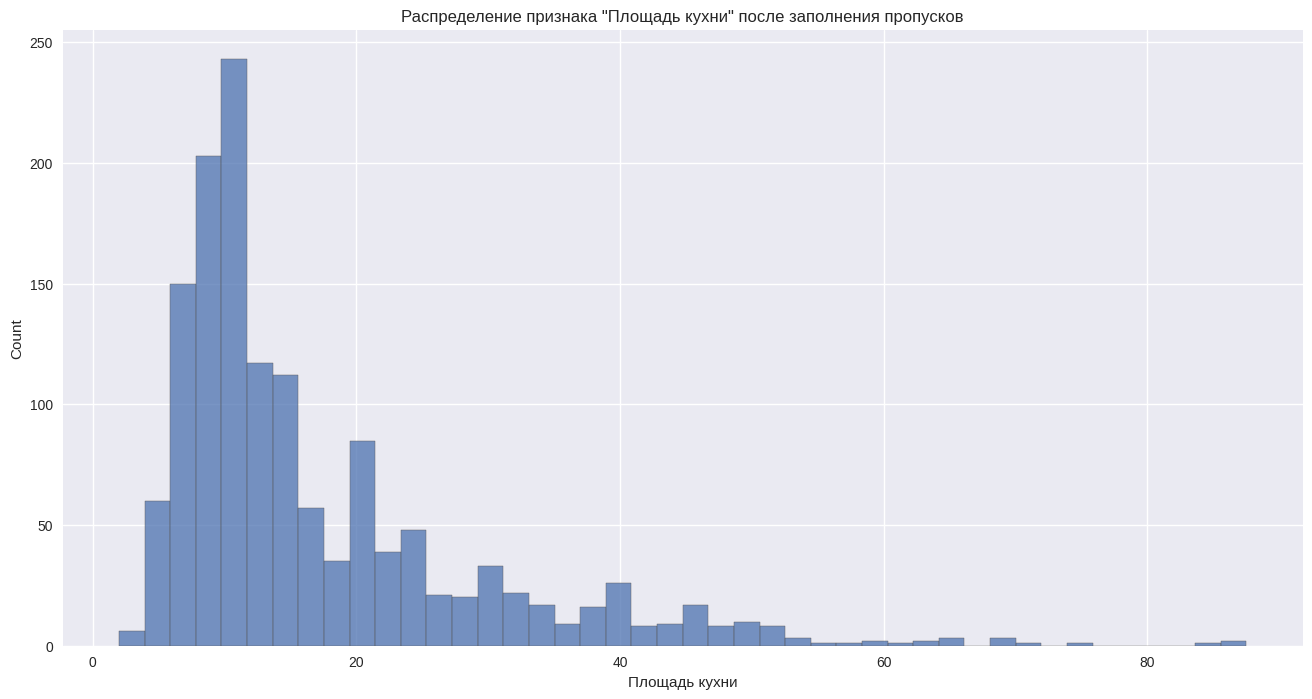

In [ ]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Площадь кухни', ax=ax)
ax.set_title('Распределение признака "Площадь кухни" после заполнения пропусков');

График стал выглядеть иначе, но общий характер сильно не пострадал, поэтому такое заполнение признака на мой взгляд является оптимальным.

**"Ближайшее метро, мин."** - в этом признаке всего два пропуска, заполним их вручную: просто посмотрим по картам сколько добираться до метро.

In [ ]:
#Заменяем пропуски на -1
data['Ближайшее метро, мин.'] = data['Ближайшее метро, мин.'].apply(lambda x: -1 if np.isnan(x) else x)

#Посмотрим, в каких адресах пропуски у этого признака.
mask = data['Ближайшее метро, мин.'] == -1
data[mask]['Адрес']

982     Россия, Москва, район Троицк, улица Яворки, 1к6
1477            Россия, Москва, Бирюлёвская улица, 45к1
Name: Адрес, dtype: object

In [ ]:
data['Ближайшее метро, мин.'].value_counts()

Ближайшее метро, мин.
 4.0     253
 5.0     225
 6.0     153
 3.0     134
 7.0     127
 8.0      98
 10.0     89
 12.0     52
 11.0     51
 9.0      50
 2.0      49
 13.0     31
 15.0     26
 14.0     23
 1.0      17
 17.0     13
 16.0      5
-1.0       2
 20.0      1
 19.0      1
Name: count, dtype: int64

Теперь воспользуемся картами в интернете и посмотрим сколько минимум добираться до метро:

    Россия, Москва, район Троицк, улица Яворки, 1к6 - 210 минут.
    Россия, Москва, Бирюлёвская улица, 45к1 - 74 минуты.

Заполняем пропуски и удаляем признак "Адрес", так как он не несет никакой полезной информации.

In [ ]:
#Произоводим замену значений в конкретных ячейках.
data.at[982, 'Ближайшее метро, мин.'] = 210
data.at[1477, 'Ближайшее метро, мин.'] = 74
data['Ближайшее метро, мин.'].value_counts()

Ближайшее метро, мин.
4.0      253
5.0      225
6.0      153
3.0      134
7.0      127
8.0       98
10.0      89
12.0      52
11.0      51
9.0       50
2.0       49
13.0      31
15.0      26
14.0      23
1.0       17
17.0      13
16.0       5
20.0       1
210.0      1
74.0       1
19.0       1
Name: count, dtype: int64

Удаляем признак.

In [ ]:
data = data.drop('Адрес', axis=1)

**Парковка** - заполняем пропуски модой.

In [ ]:
data['Парковка'] = data['Парковка'].fillna(data['Парковка'].mode()[0])
data['Парковка'].value_counts()

Парковка
ground         880
underground    464
open            29
multilevel      27
Name: count, dtype: int64

Убедимся, что в данных не осталось пропусков.

In [ ]:
f'Кол-во пропусков в данных: {data.isnull().sum().sum()}'

'Кол-во пропусков в данных: 0'

## Разведовательный анализ данных

На этом этапе мы посмотрим, как целевая переменныя зависит от остальных признаков, попытаемся обнаружить выбросы и избавиться от них. Также, если получится, то займемся генерацией признаков и статистическими тестами для проверки гипотез.

### **Целевая переменная**

Давайте взглянем на распределение нашего таргета:

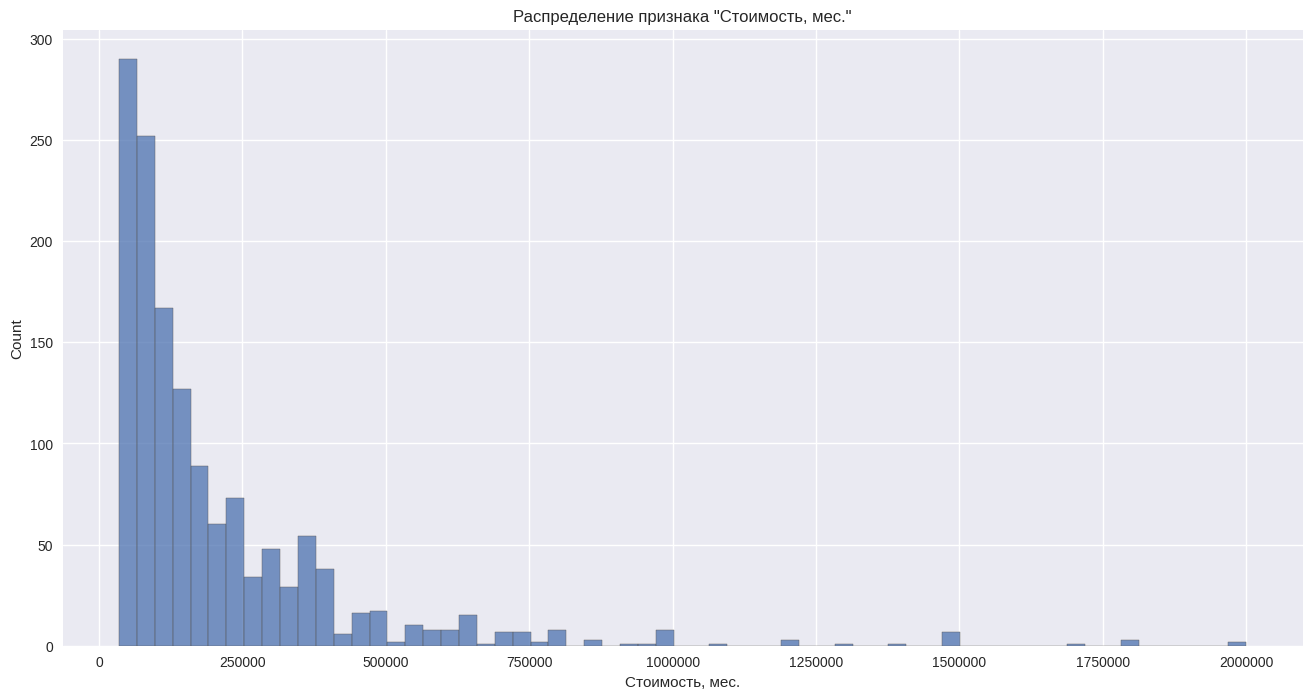

In [ ]:
#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Стоимость, мес.', ax=ax)
ax.set_title('Распределение признака "Стоимость, мес."');

Распределение признака напоминает логарифмическое, давайте попробуем привести его к нормальному виду.

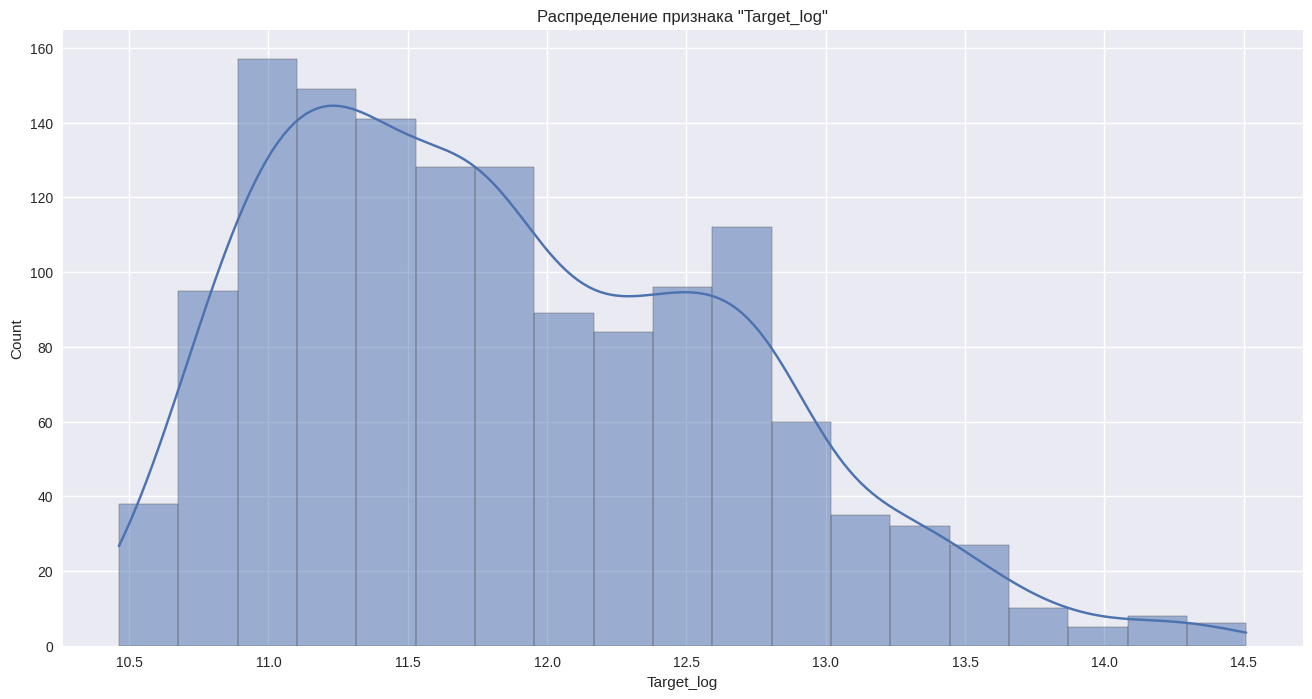

In [ ]:
data['Target_log'] = data['Стоимость, мес.'].apply(lambda x: np.log(x + 1))

#Визуализируем гистограмму логарифма от целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Target_log', kde=True, ax=ax)
ax.set_title('Распределение признака "Target_log"');

### **Этаж и Кол-во этажей**

Давайте создадим новые признаки на основе этих: "Последний этаж", если квартира на последнем этаже здания, и "Первый этаж", если на первом.

In [ ]:
def last_first_floor(data):
    #Создаем столбцы будущих признаков
    data['Последний этаж'] = np.zeros(data.shape[0])
    data['Первый этаж'] = np.zeros(data.shape[0])
    #Заполняем значения в соответствии логике, описанной выше
    for index, row in data.iterrows():
        if row['Этаж'] == row['Кол-во этажей']:
            data.at[index, 'Последний этаж'] = 1
        elif row['Этаж'] == 1:
            data.at[index, 'Первый этаж'] = 1
        else:
            pass
    #Возвращаем обновленную таблицу    
    return data

#Генерируем новые признаки
data = last_first_floor(data)
data.head()

,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж
0,20,23,75.0,45.5,10.0,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0
1,3,10,173.0,130.0,24.0,3,True,ЦАО,8.0,950000,0,True,0,1,underground,13.764218,0.0,0.0
2,23,23,42.0,18.0,9.0,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0
3,8,10,125.0,72.0,16.0,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0
4,45,75,120.0,120.0,40.0,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0


Посмотрим на распределения получившихся признаков.

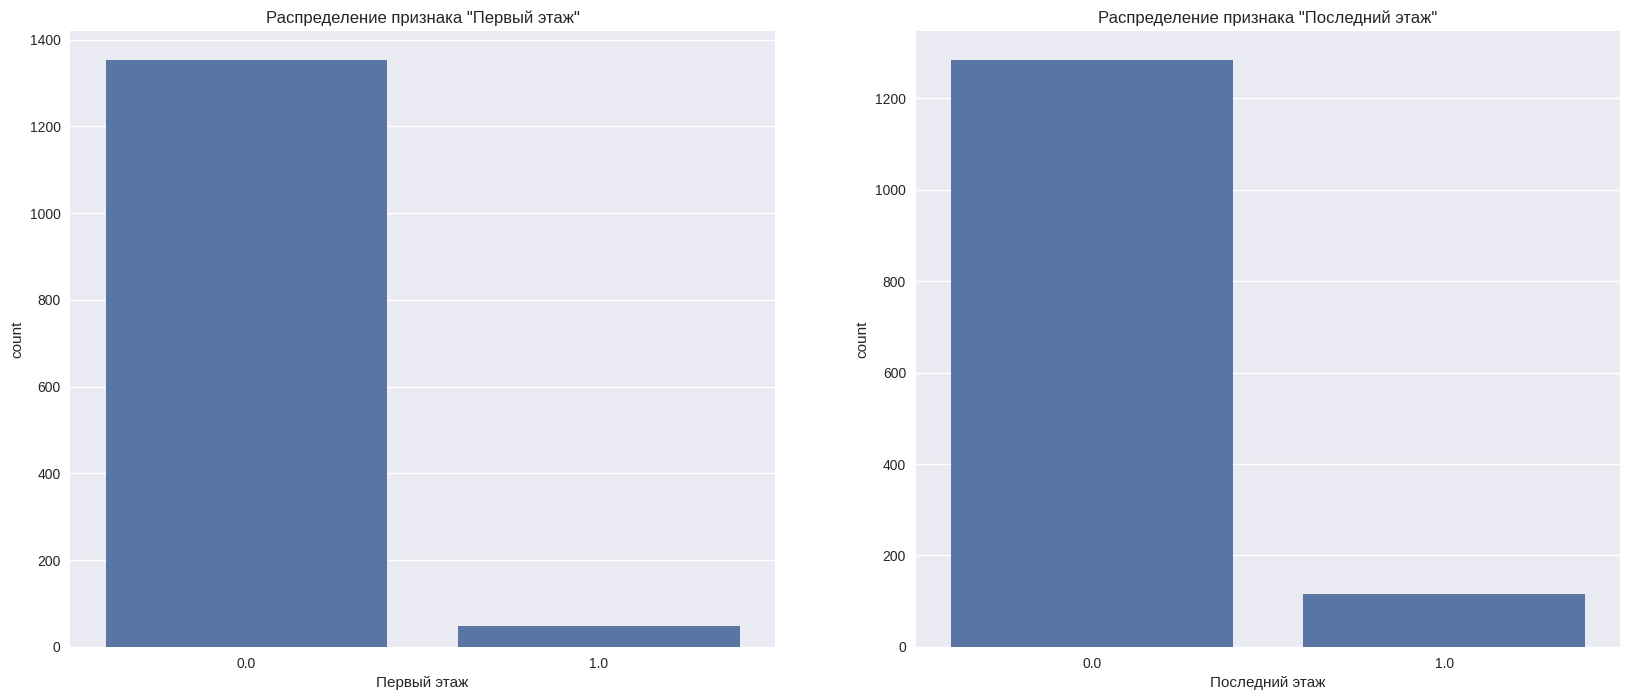

In [ ]:
#Строим графики распределений признаков
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(data, x='Первый этаж', ax=axes[0])
axes[0].set_title('Распределение признака "Первый этаж"')
sns.countplot(data, x='Последний этаж', ax=axes[1])
axes[1].set_title('Распределение признака "Последний этаж"');

В признаках присутствует сильный дисбаланс классов - такое поведение является ожидаемым. Давайте посмотрим на целевую переменную в разрезе этих признаков.

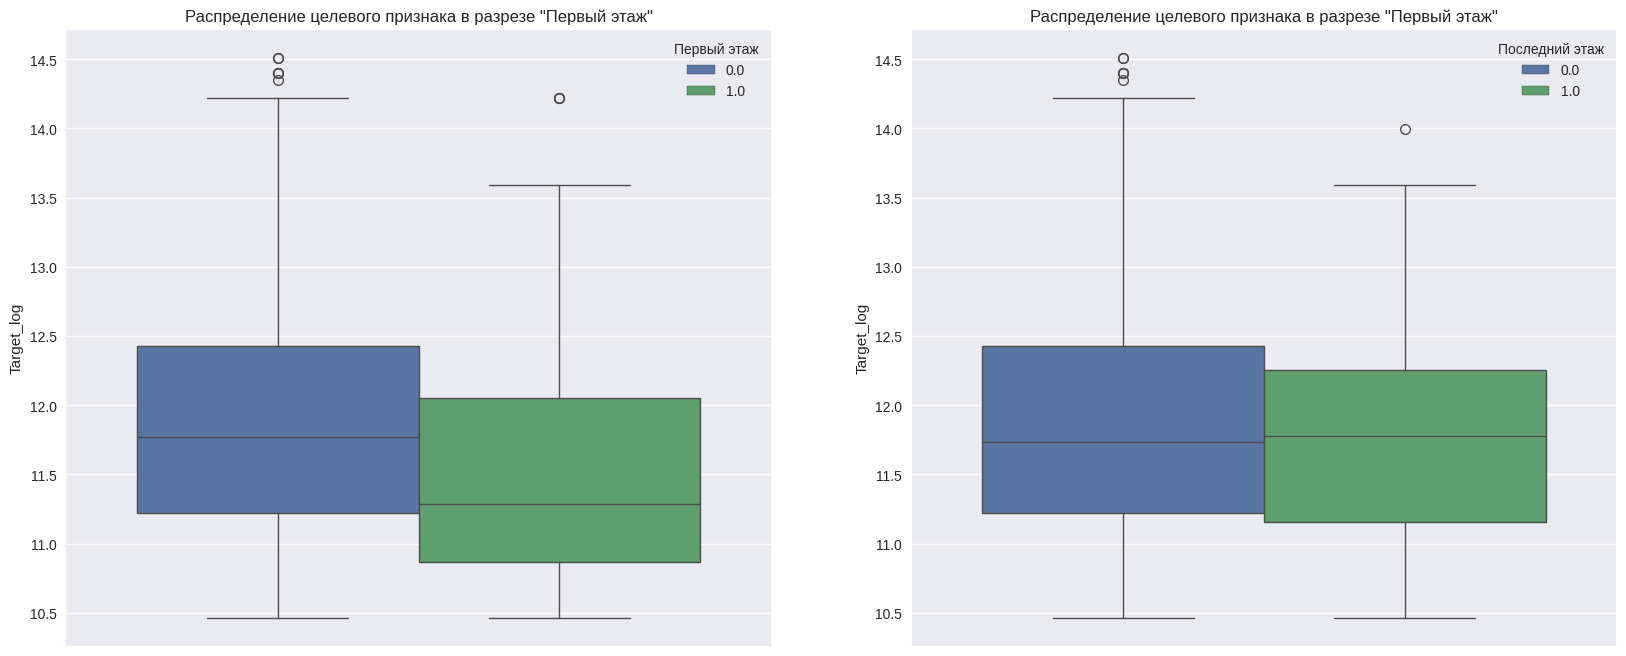

In [ ]:
#Строим графики
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data, y='Target_log', hue='Первый этаж', ax=axes[0])
axes[0].set_title('Распределение целевого признака в разрезе "Первый этаж"')
sns.boxplot(data, y='Target_log', hue='Последний этаж', ax=axes[1])
axes[1].set_title('Распределение целевого признака в разрезе "Первый этаж"');

Зависисимость целевой переменной от кол-ва этажей в здании.

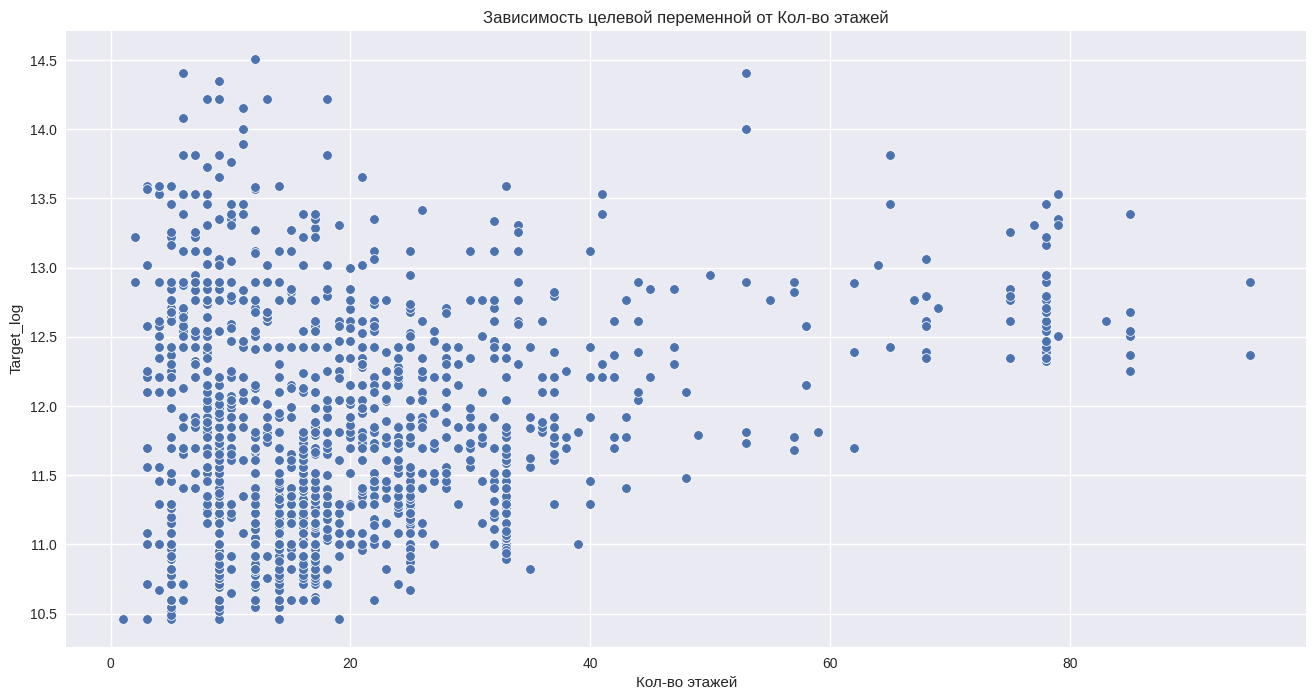

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data=data, x='Кол-во этажей', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от Кол-во этажей');

Также посмотрим на то, как завивисит целевая переменная от этажа квартиры.

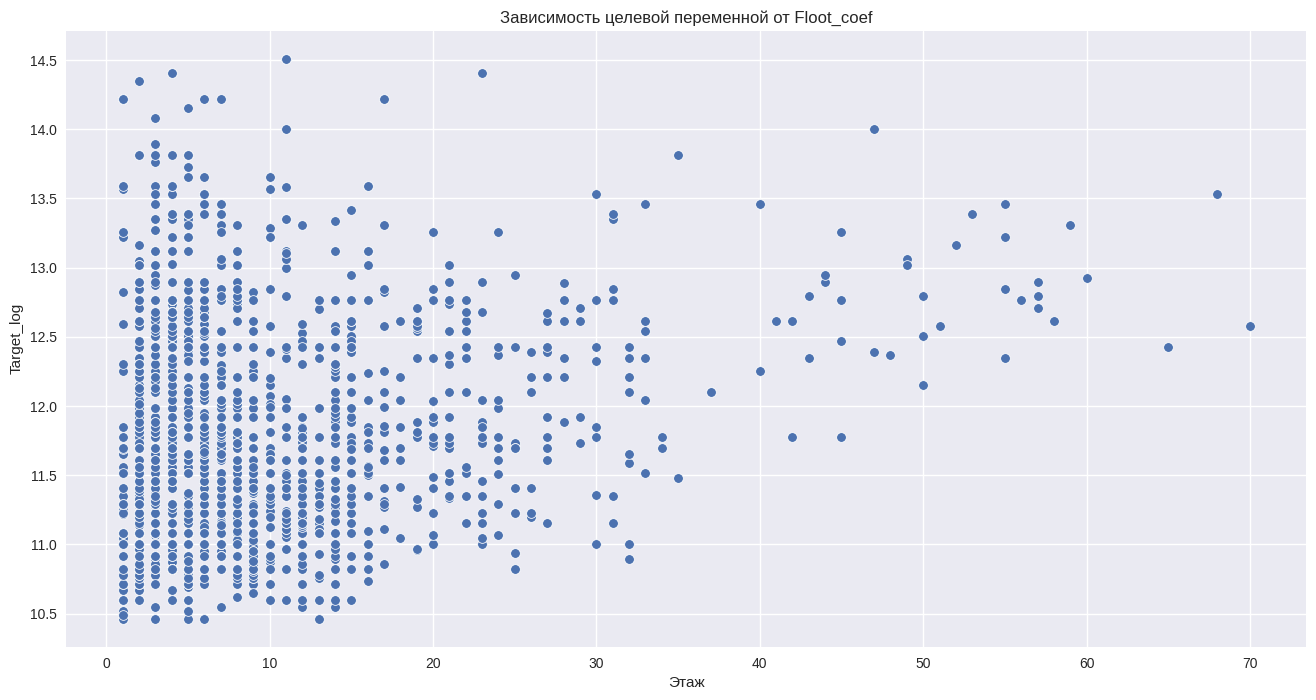

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data=data, x='Этаж', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от Floot_coef');

Видим, что в обоих случая присутствует корреляция, да слабая, но есть, при чем она является положительной.

### **Площадь**

Изучим зависимость целевой переменной от площади квартиры.

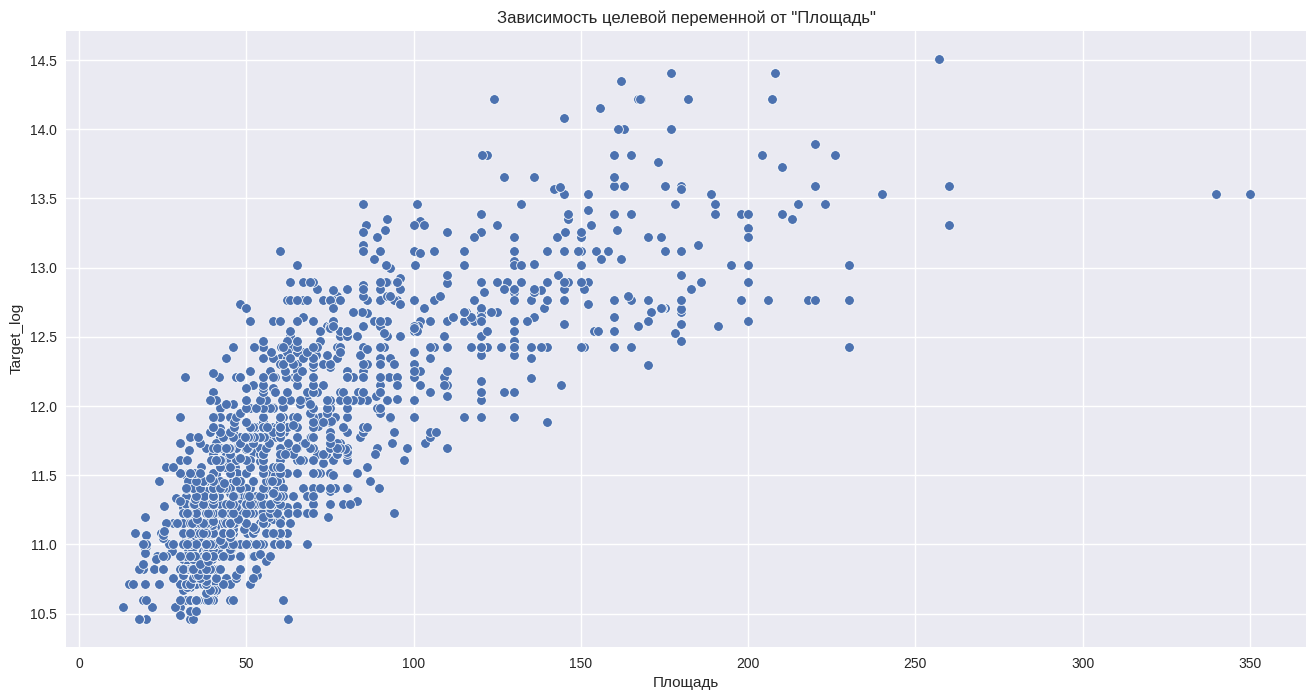

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Площадь', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Площадь"');

Видно, что признаки коррелируют друг с другом, при чем корреляция является не линейной, попробуем это исправить. Посмотрим на распределение признака.

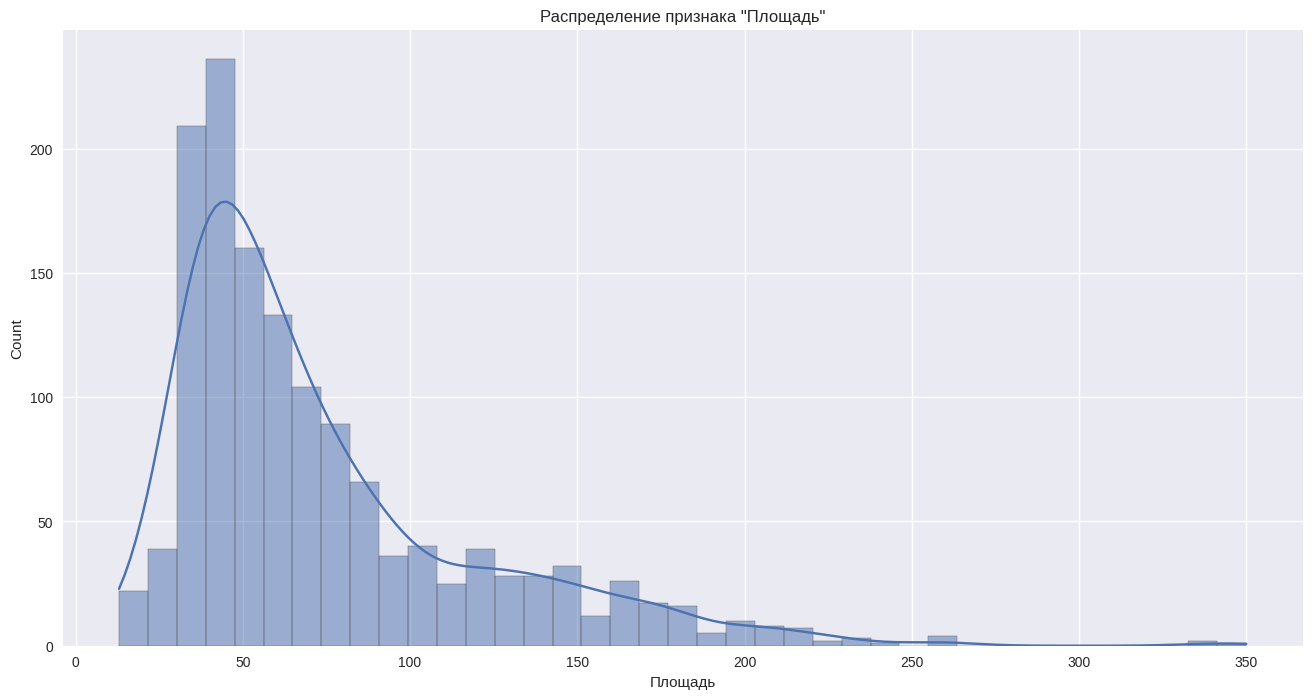

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Площадь', kde=True, ax=ax)
ax.set_title('Распределение признака "Площадь"');

Распределение, как и у целевой переменной, имеет характер похожий на логарифмическое с длинным хвостом, попробуем преобразовать этот признак, сделав его более нормальным.

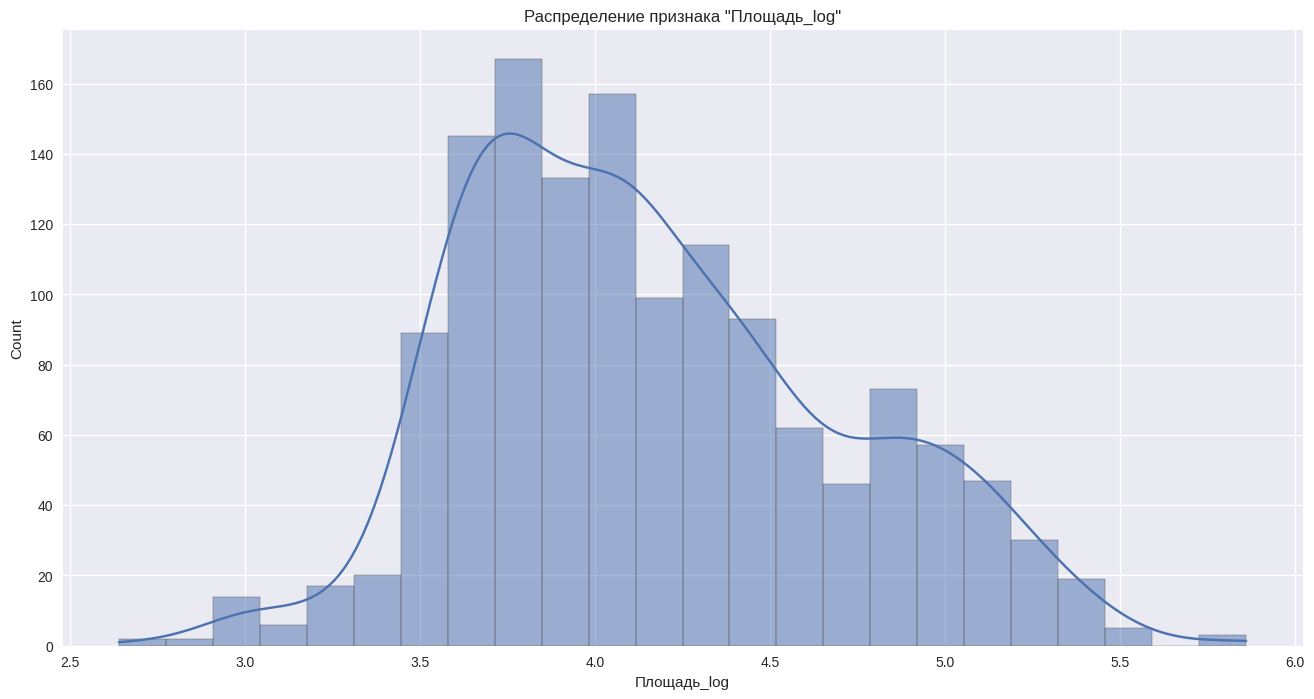

In [ ]:
data['Площадь_log'] = data['Площадь'].apply(lambda x: np.log(1 + x))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Площадь_log', kde=True, ax=ax)
ax.set_title('Распределение признака "Площадь_log"');

Теперь распределение стало больше похоже на нормальное, удаляем исходный признак.

In [ ]:
data = data.drop('Площадь', axis=1)
data.head()

,Этаж,Кол-во этажей,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log
0,20,23,45.5,10.0,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0,4.330733
1,3,10,130.0,24.0,3,True,ЦАО,8.0,950000,0,True,0,1,underground,13.764218,0.0,0.0,5.159055
2,23,23,18.0,9.0,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0,3.761200
3,8,10,72.0,16.0,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0,4.836282
4,45,75,120.0,40.0,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0,4.795791


Посмотрим, как зависит таргет от преобразованной переменной.

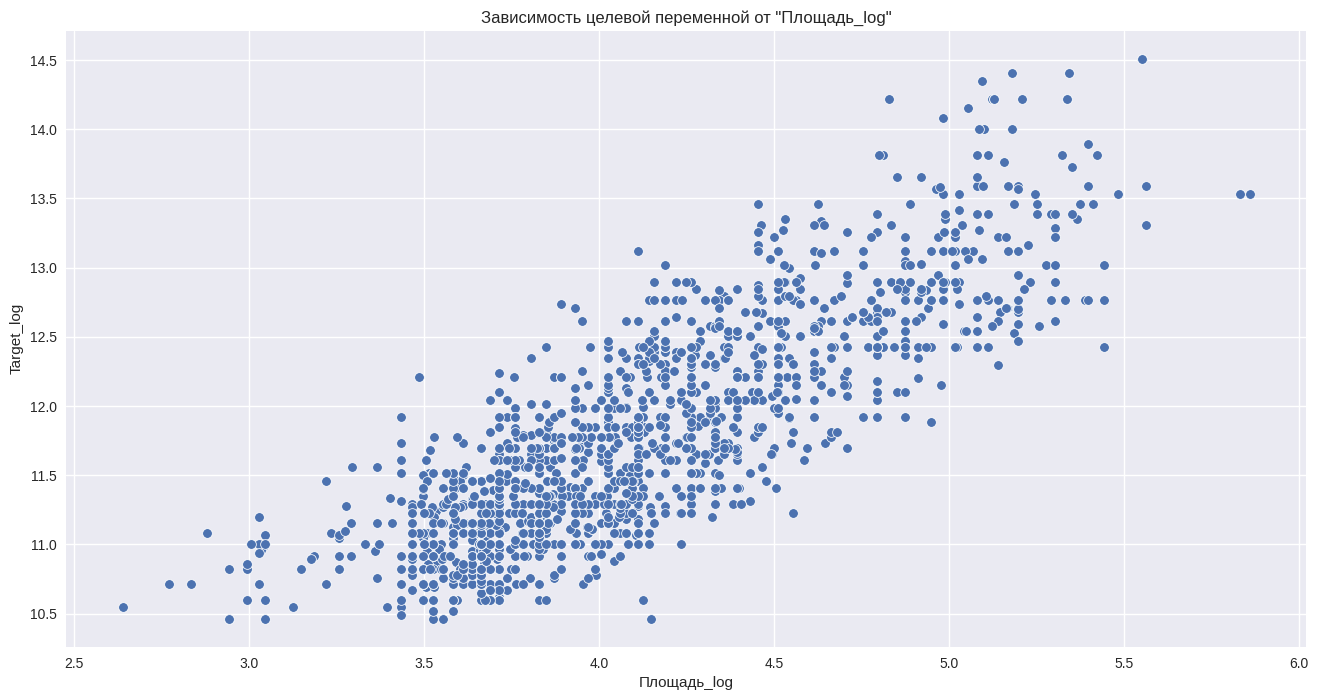

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Площадь_log', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Площадь_log"');

Теперь зависимость стала более простой.

### **Жилая площадь**

Также рассмотрим распределение признака.

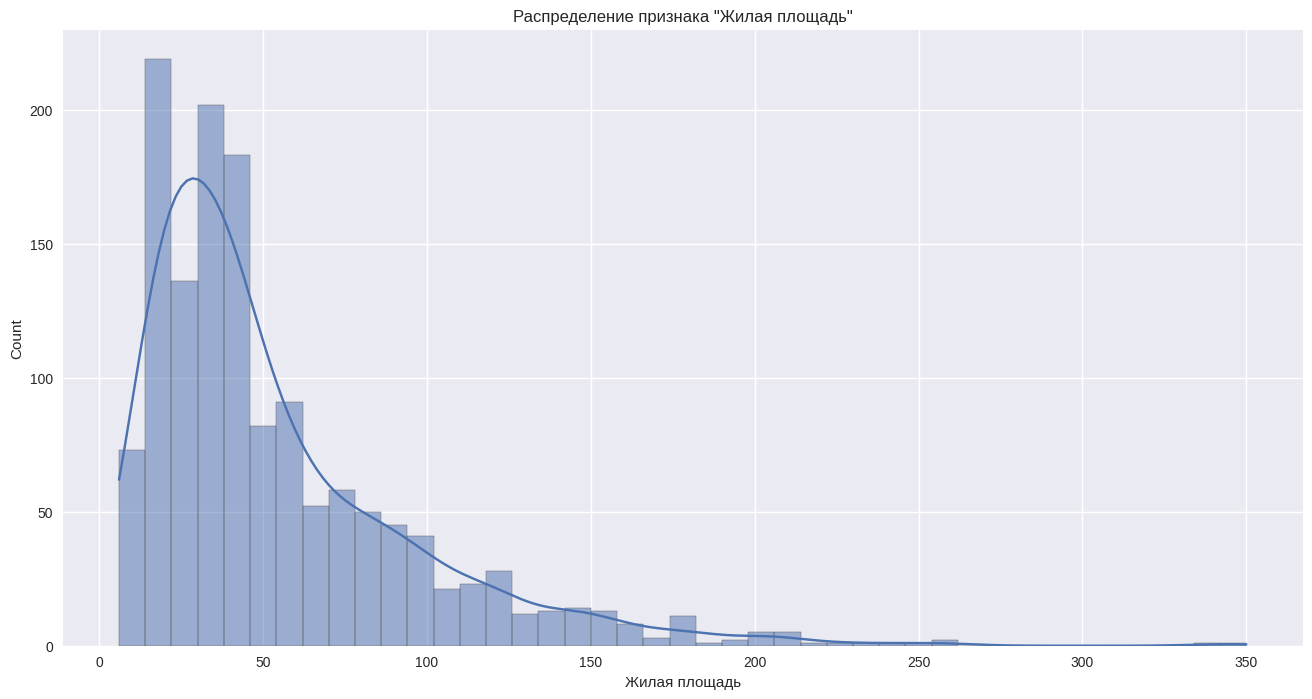

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Жилая площадь', kde=True, ax=ax)
ax.set_title('Распределение признака "Жилая площадь"');

Посмотрим, как этот признак влияет на целевую переменную.

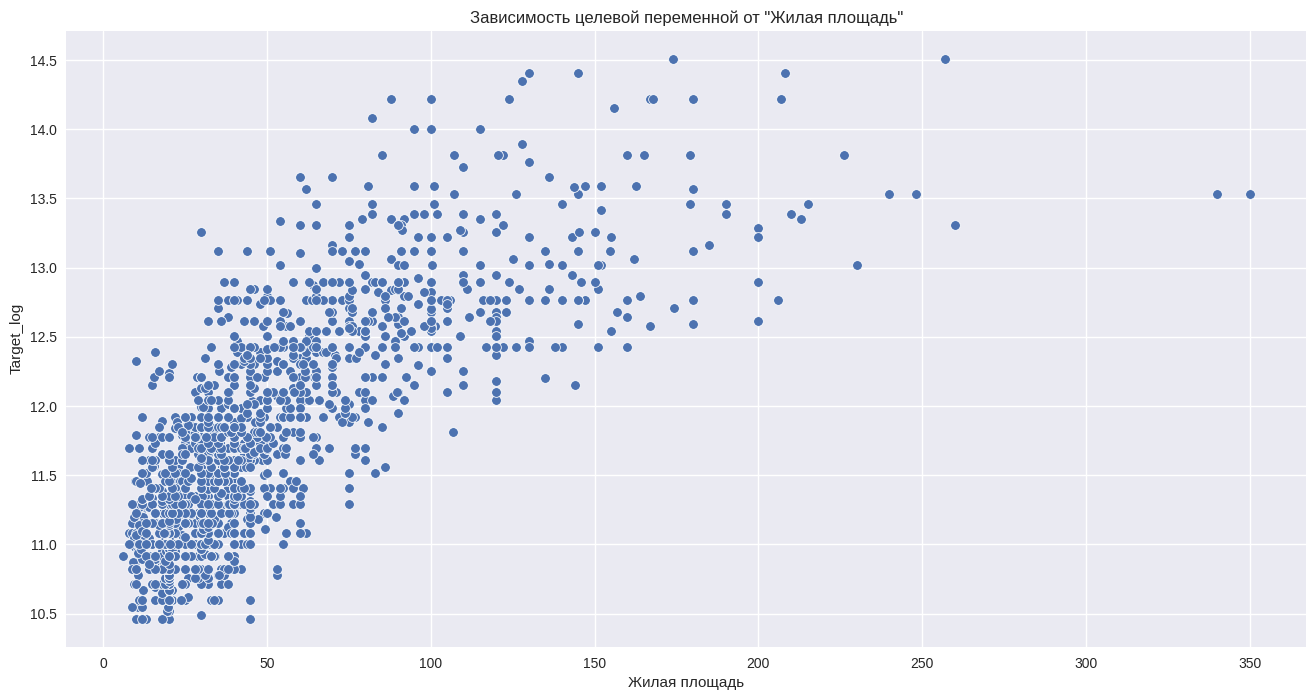

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Жилая площадь', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Жилая площадь"');

Поступим также, как с признакам площади квартиры.

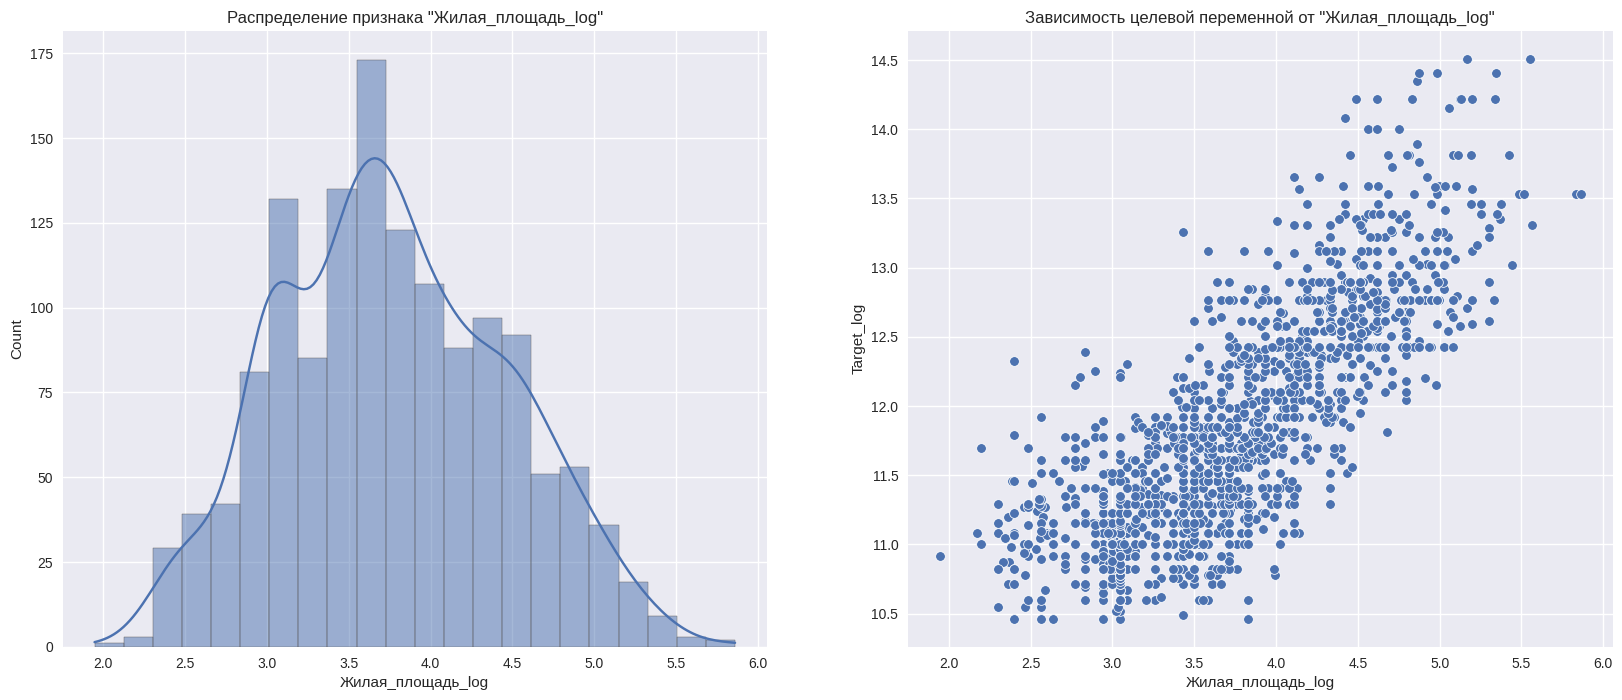

In [ ]:
data['Жилая_площадь_log'] = data['Жилая площадь'].apply(lambda x: np.log(1 + x))
data = data.drop('Жилая площадь', axis=1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Жилая_площадь_log', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Жилая_площадь_log"')

sns.scatterplot(data, x='Жилая_площадь_log', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Жилая_площадь_log"');

Распределение стало более нормальным, а зависимость более понятной.

### **Площадь кухни**

С этим признаком мы уже немного работали, заполняли в нем пропуски. Давайте снова посмотрим на его распределение, а также на зависимость целевой переменной.

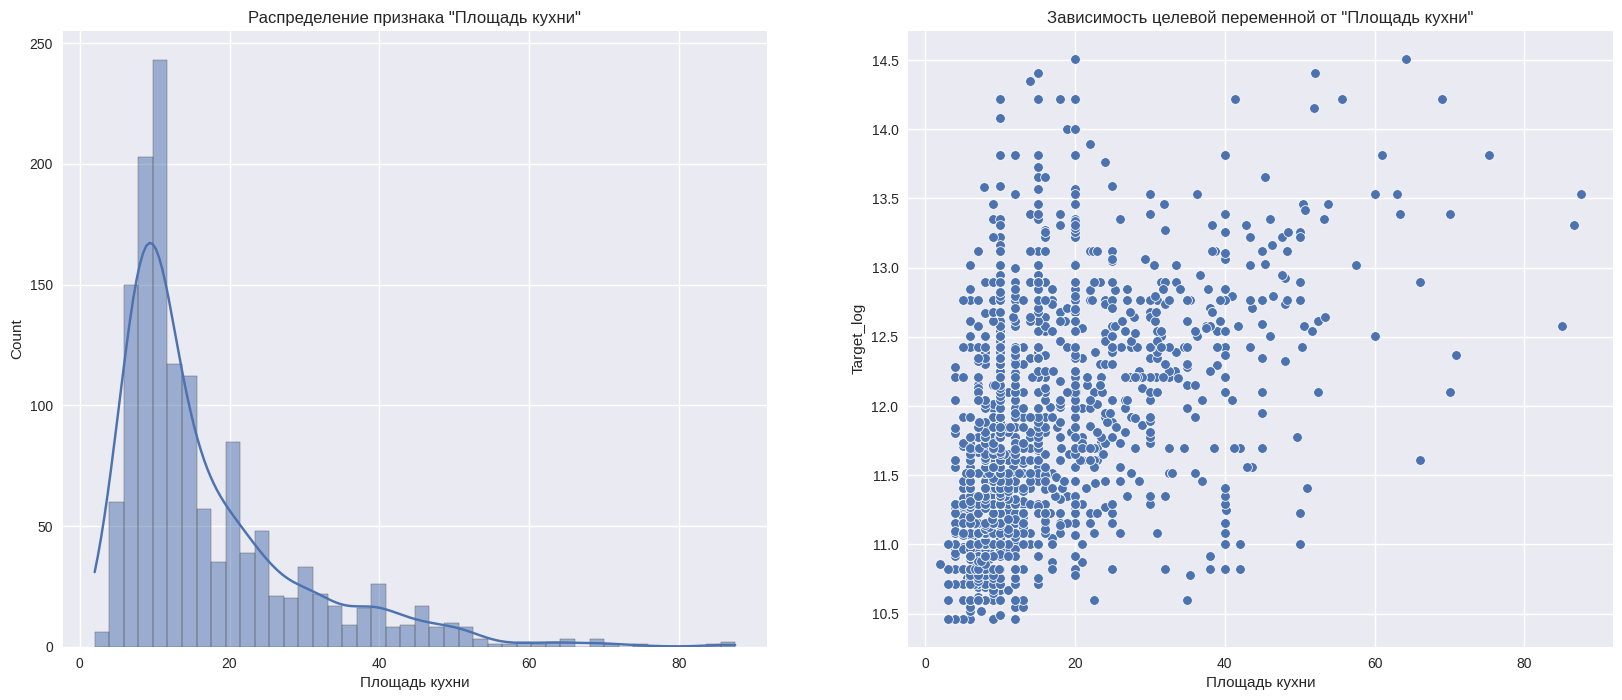

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Площадь кухни', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Площадь кухни"')

sns.scatterplot(data, x='Площадь кухни', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Площадь кухни"');

Распределение имеет похожий характер на предыдущие признаки - это логично все три признакак по сути описывают одно и тоже явление. Корреляция с целевой переменной является более слабой, давайте попробуем повторить наш трюк.

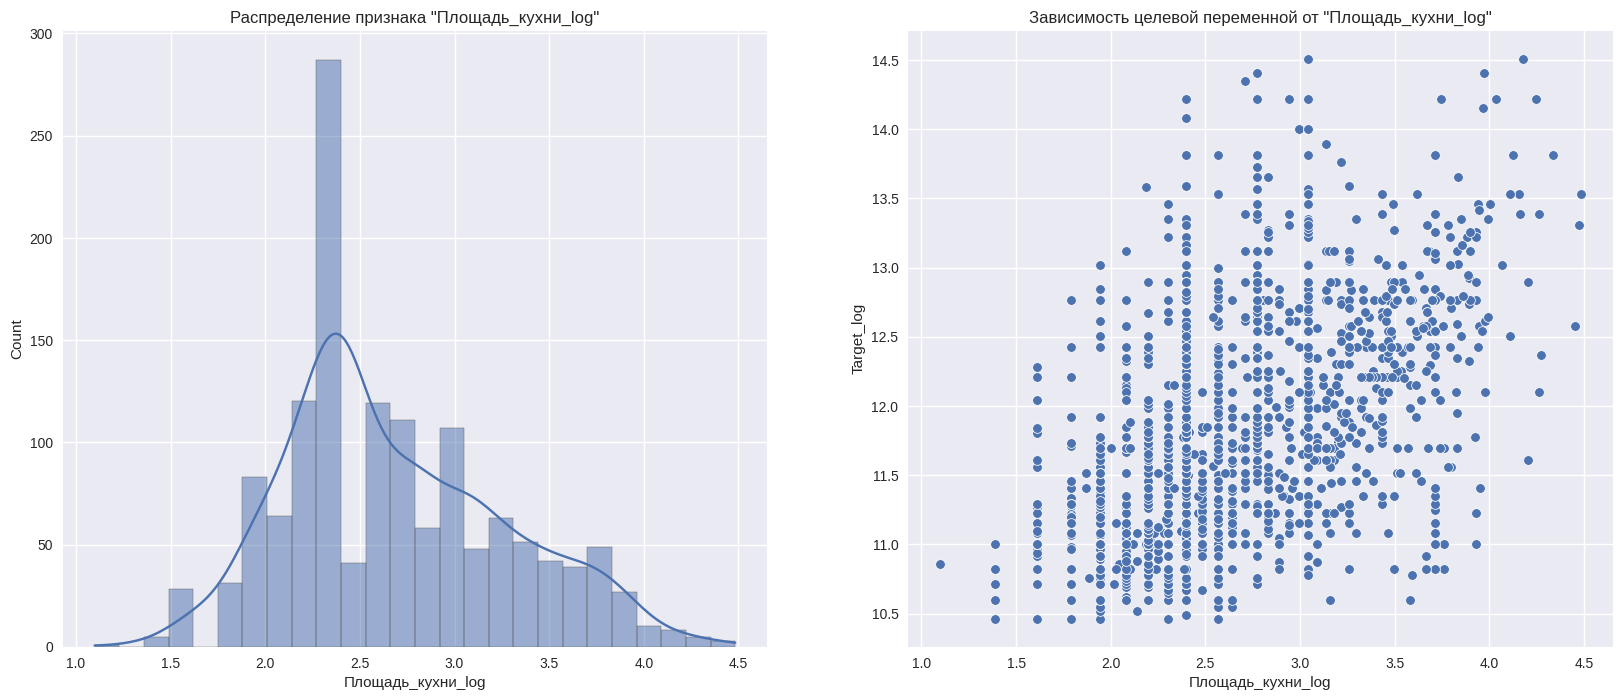

In [ ]:
data['Площадь_кухни_log'] = data['Площадь кухни'].apply(lambda x: np.log(1 + x))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Площадь_кухни_log', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Площадь_кухни_log"')

sns.scatterplot(data, x='Площадь_кухни_log', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Площадь_кухни_log"');

Мне не нравится результат, давайте посмотрим на коэффициент корреляции исходного признака и преобразованного с целевой переменной, оставим тот, у которого она больше по модулю.

In [ ]:
data[['Площадь кухни', 'Площадь_кухни_log', 'Target_log']].corr()

,Площадь кухни,Площадь_кухни_log,Target_log
Площадь кухни,1.000000,0.940789,0.458339
Площадь_кухни_log,0.940789,1.000000,0.496512
Target_log,0.458339,0.496512,1.000000


У преобразованного признака корреляция больше, оставляем его.

In [ ]:
data = data.drop('Площадь кухни', axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log
0,20,23,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895
1,3,10,3,True,ЦАО,8.0,950000,0,True,0,1,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876
2,23,23,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585
3,8,10,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213
4,45,75,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572


### **Кол-во комнат**

Распределение признака:

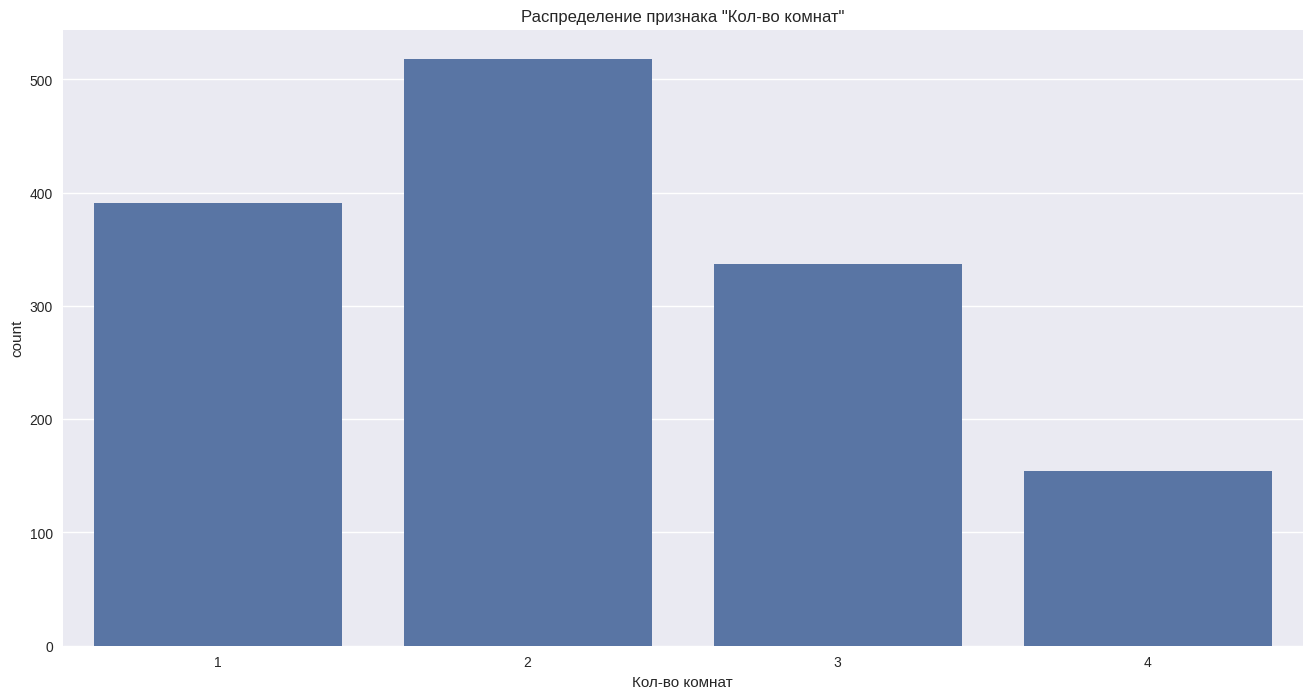

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во комнат', ax=ax)
ax.set_title('Распределение признака "Кол-во комнат"');

Преобладают 2-х комнатные квартиры, меньше всего 4-х комнатных квартир. Давайте посмотрим на уелевую переменную в разрезе этого признака.

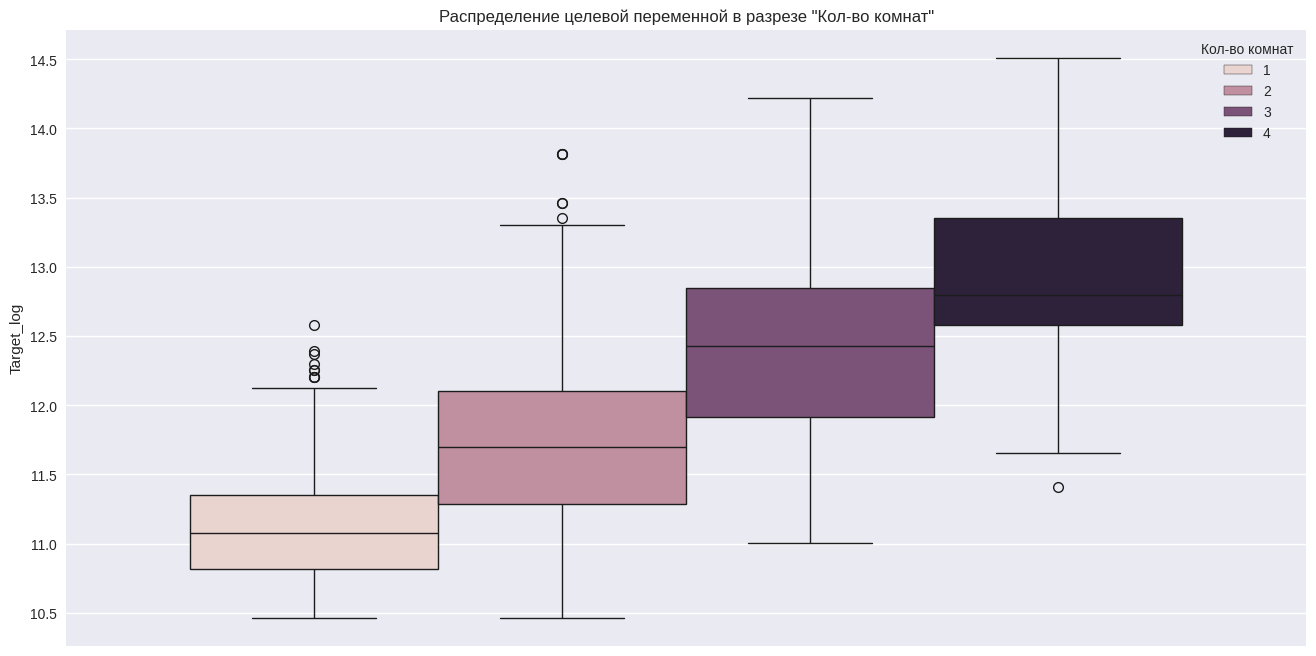

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Кол-во комнат', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Кол-во комнат"');

Здесь четко прослеживается зависимость, чем больше комнат, тем больше стоимость.

### **Наличие мебели**

Посмотрим на классы этого признака в разрезе кол-ва комнат:

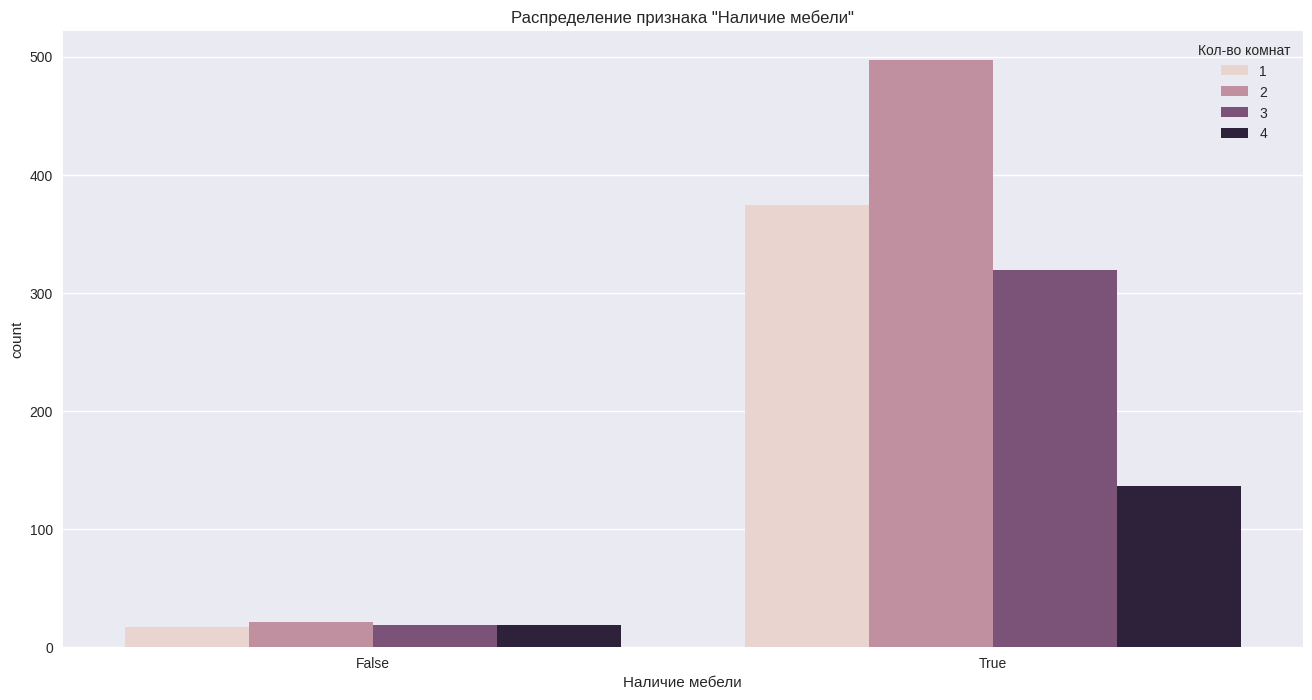

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие мебели', hue='Кол-во комнат', ax=ax)
ax.set_title('Распределение признака "Наличие мебели"');

Очень сильный дисбаланс классов, посмотрим на то, как ведет себя целевая переменная в зависимости от этого признака в разрезе кол-ва комнат.

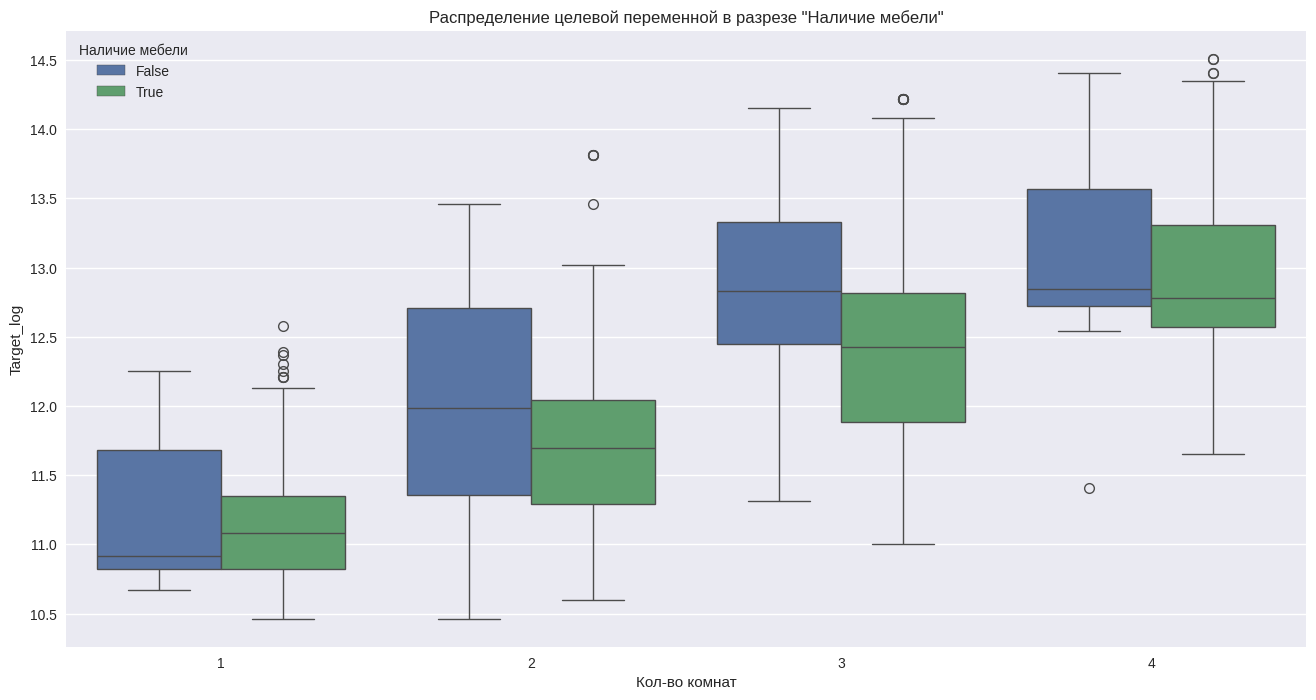

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', x='Кол-во комнат', hue='Наличие мебели', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие мебели"');

В некоторых случаях квартиры без мебели стоят дороже, чем с мебелью, это может быть связано с тем, что в новых квартирах мебель еще не завезли, а также с тем, что кол-во наблюдений без мебели слишком мало и это искажает общую статистику.

### **Округ**

Посмотрим, какие округи есть:

In [ ]:
data['Округ'].unique().tolist()

['СЗАО',
 'ЦАО',
 'НАО (Новомосковский)',
 'ЗАО',
 'САО',
 'ЮАО',
 'СВАО',
 'ЮЗАО',
 'ЗелАО',
 'ЮВАО',
 'ВАО']

Округи соответсвуеют действительности, посмотрим на распределение.

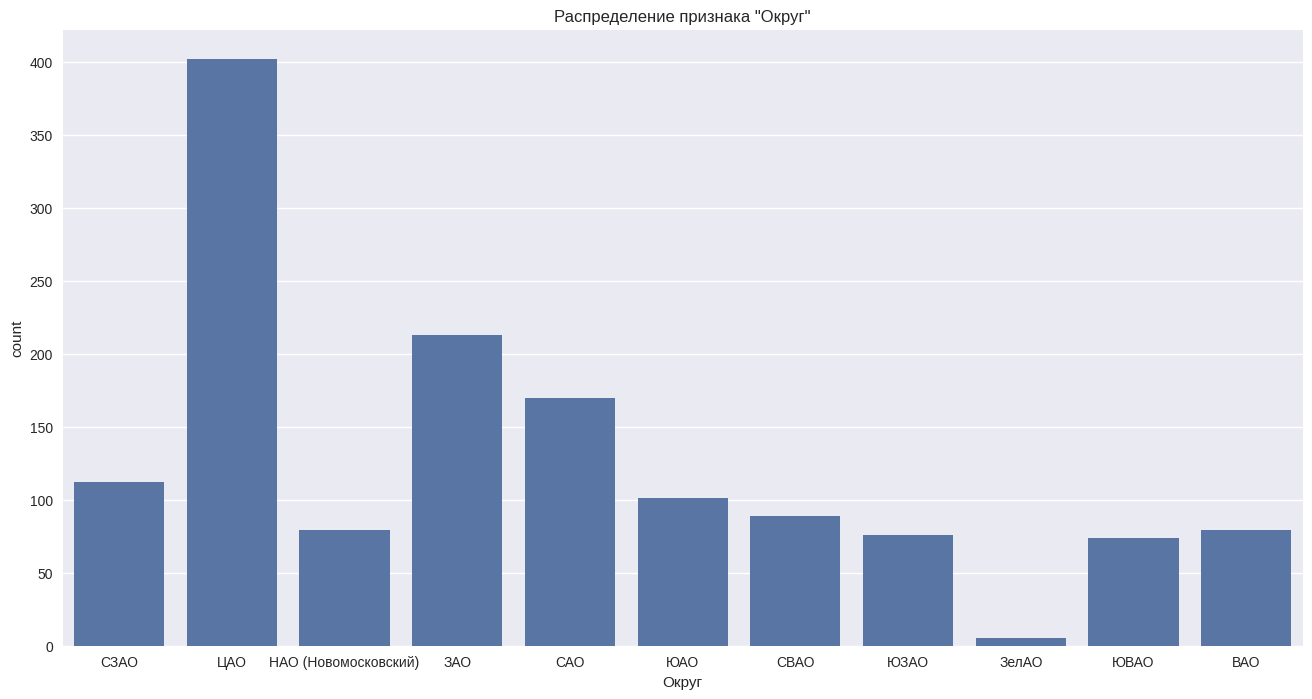

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Округ', ax=ax)
ax.set_title('Распределение признака "Округ"');

Посмотрим на наш таргет в разрезе этого признака.

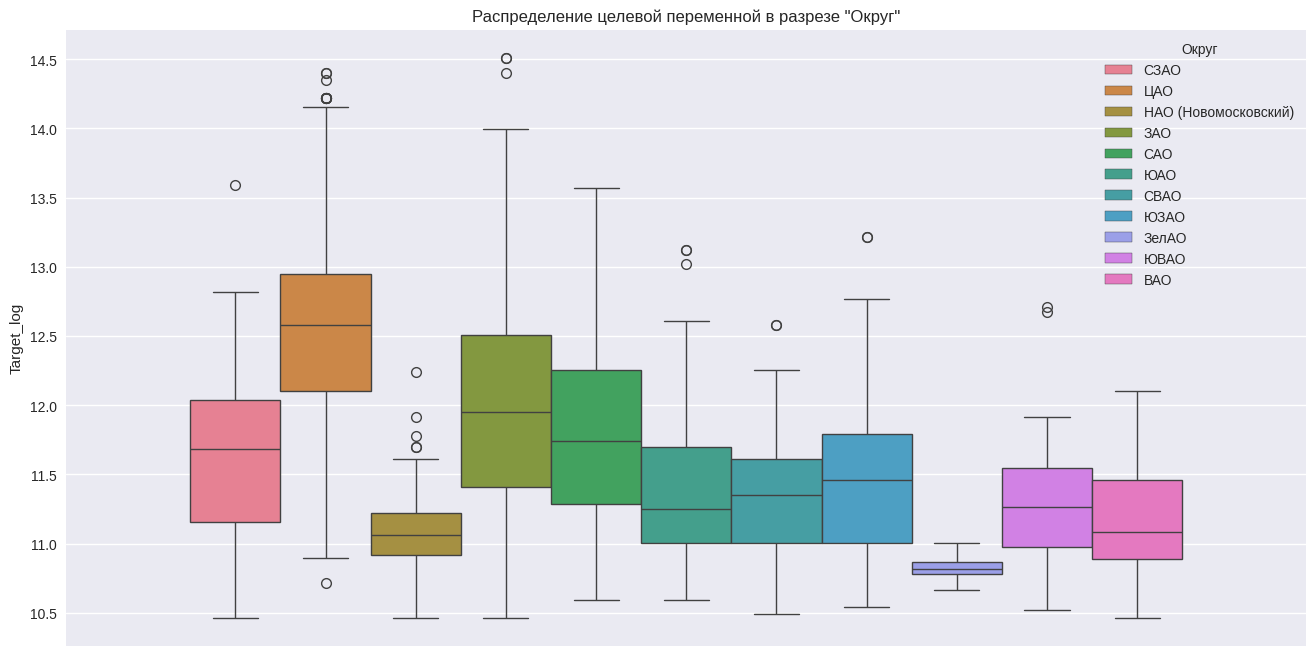

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Округ', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Округ"');

Заметим, что выделяются следующие округи: ЦАО, НАО, ЗАО и САО, остальные имеют схожую цену, давайте объеденим их в один.

In [ ]:
def preprocessing(x):
    if x in ['СЗАО', 'ЮАО', 'СВАО', 'ЮЗАО', 'ЗелАО', 'ЮВАО', 'ВАО']:
        return 'other'
    else:
        return x
    
data['Округ'] = data['Округ'].apply(lambda x: preprocessing(x))
data['Округ'].unique()

array(['other', 'ЦАО', 'НАО (Новомосковский)', 'ЗАО', 'САО'], dtype=object)

Таргет для преобразованного признака:

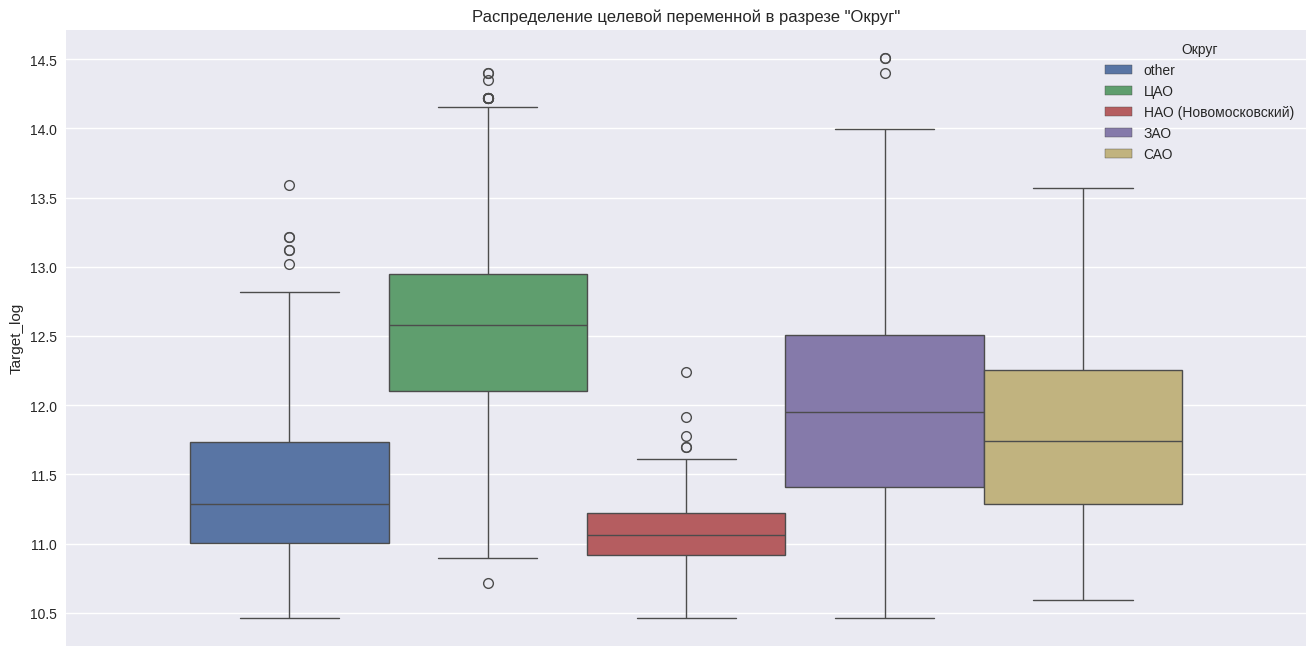

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Округ', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Округ"');

###  **Кол-во балконов**

Распределение:

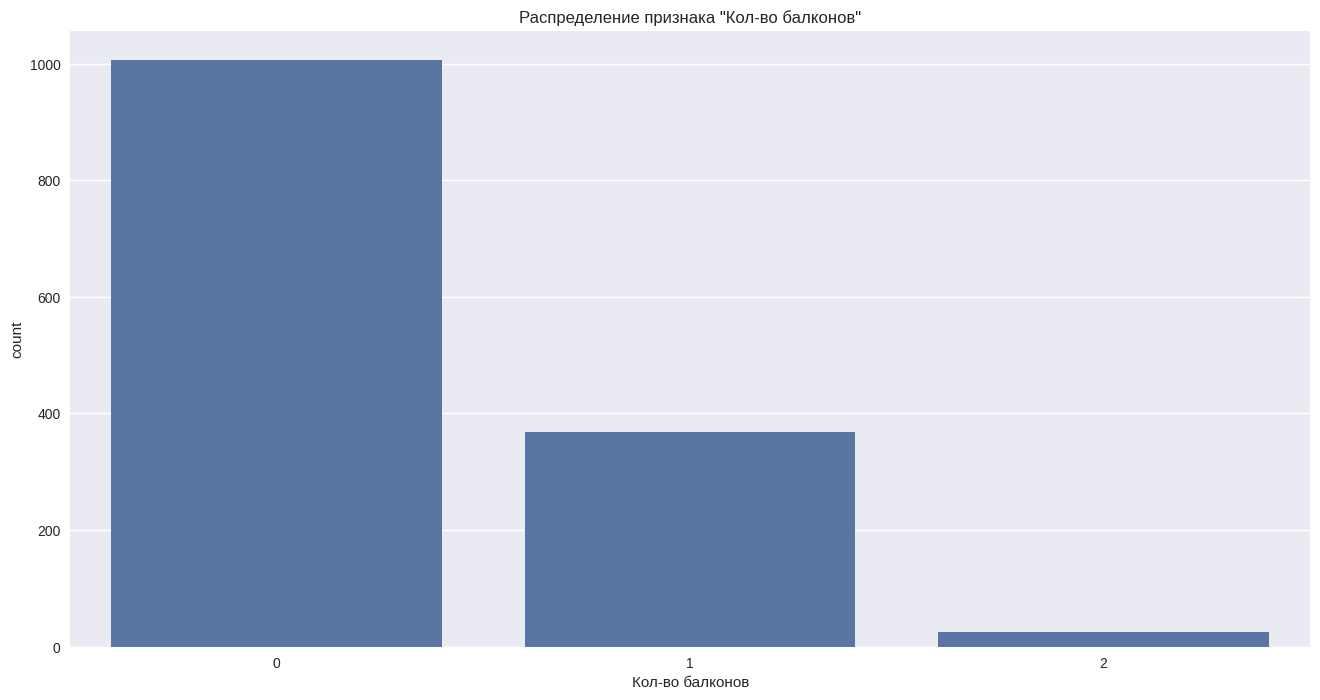

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во балконов', ax=ax)
ax.set_title('Распределение признака "Кол-во балконов"');

Видим, что в классах присутствует дисбаланс, поэтому создадим новый признак "Наличие балкона" - 1 если есть, 0 - если отсутствует.

In [ ]:
data['Наличие балкона'] = data['Кол-во балконов'].apply(lambda x: 0 if x == 0 else 1)
data = data.drop('Кол-во балконов', axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0
1,3,10,3,True,ЦАО,8.0,950000,True,0,1,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876,0
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0


Распределение нового признака:

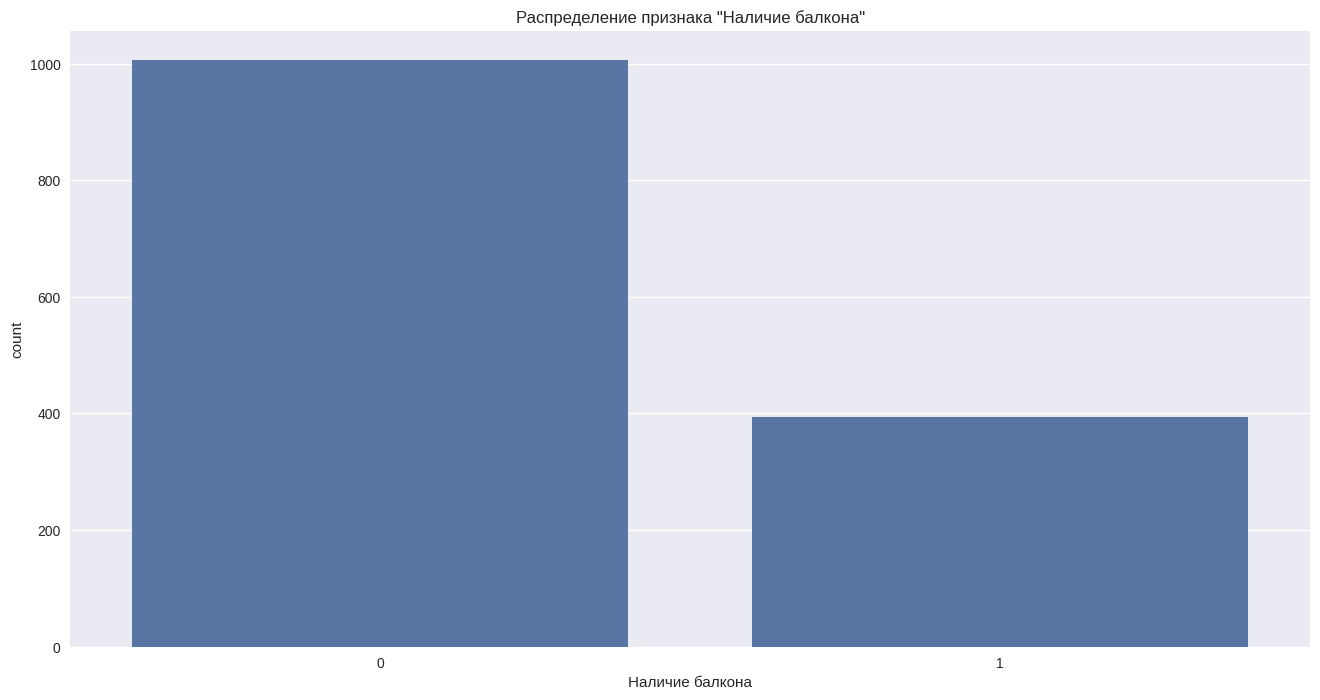

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие балкона', ax=ax)
ax.set_title('Распределение признака "Наличие балкона"');

Таргет в разрезе нового признака:

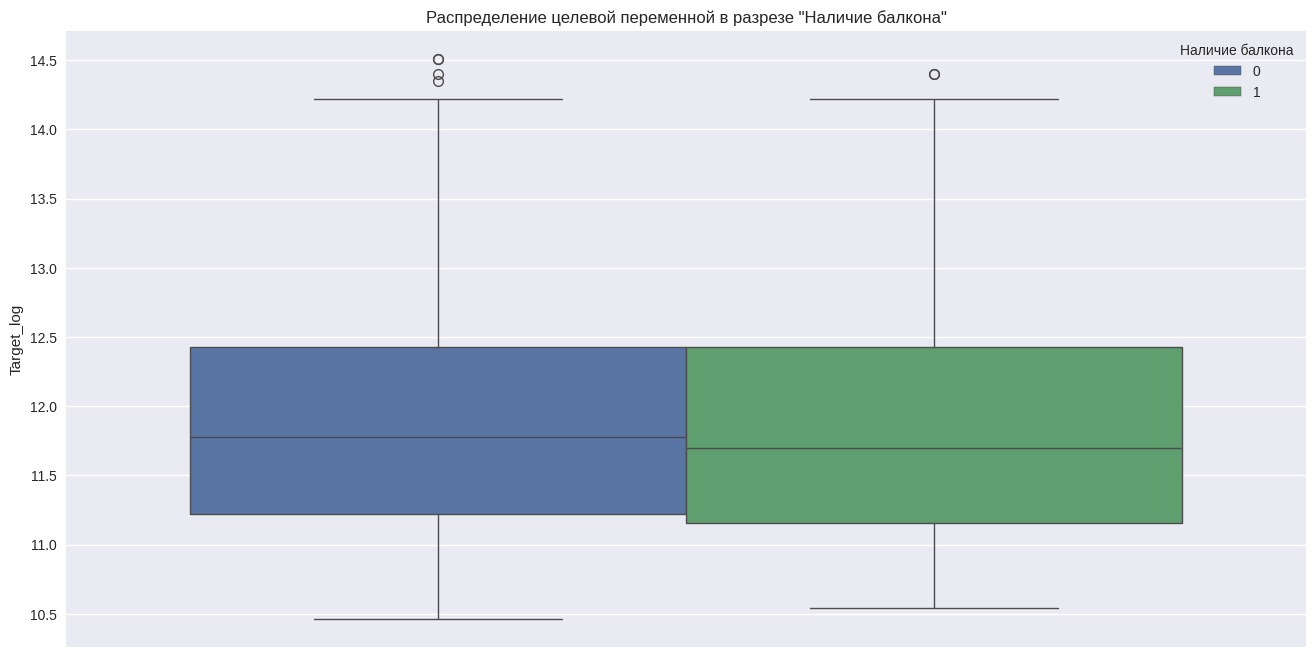

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Наличие балкона', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие балкона"');

Цены на квартиры с балконом и без почти не отличаются.

### **Продажа от агента**

Распределение признака:

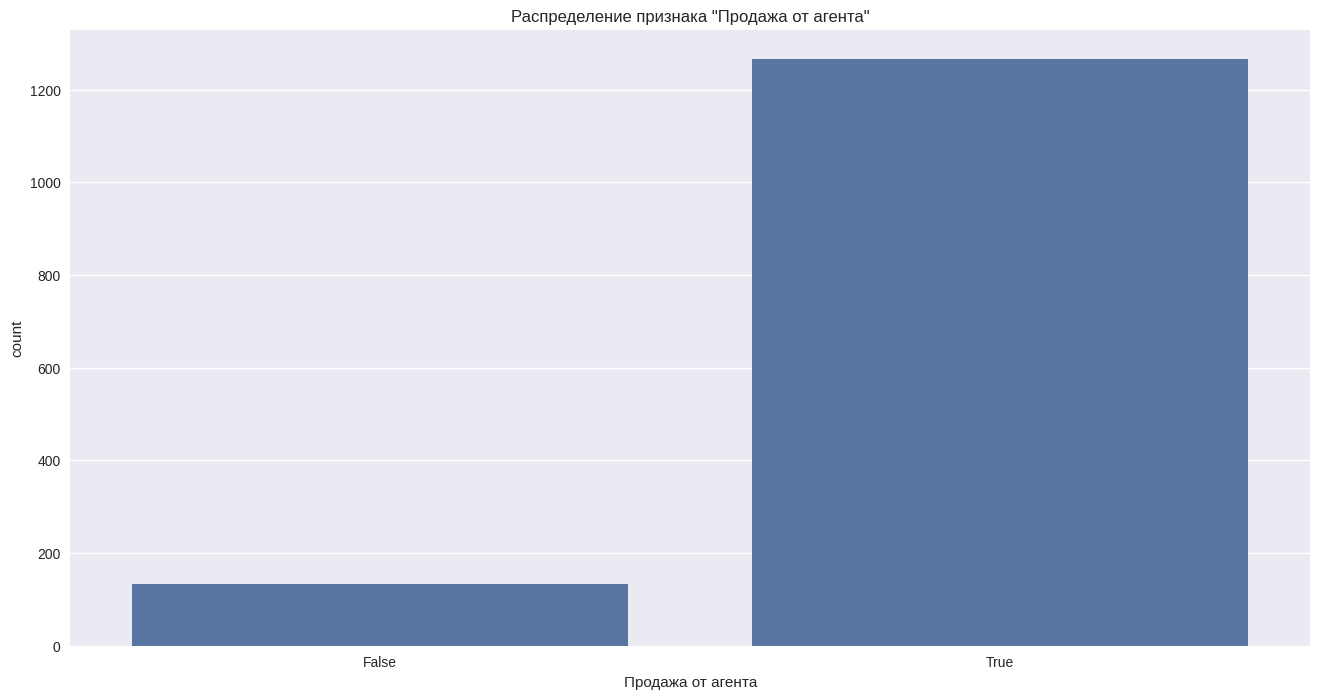

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Продажа от агента', ax=ax)
ax.set_title('Распределение признака "Продажа от агента"');

Таргет в разрезе признака:

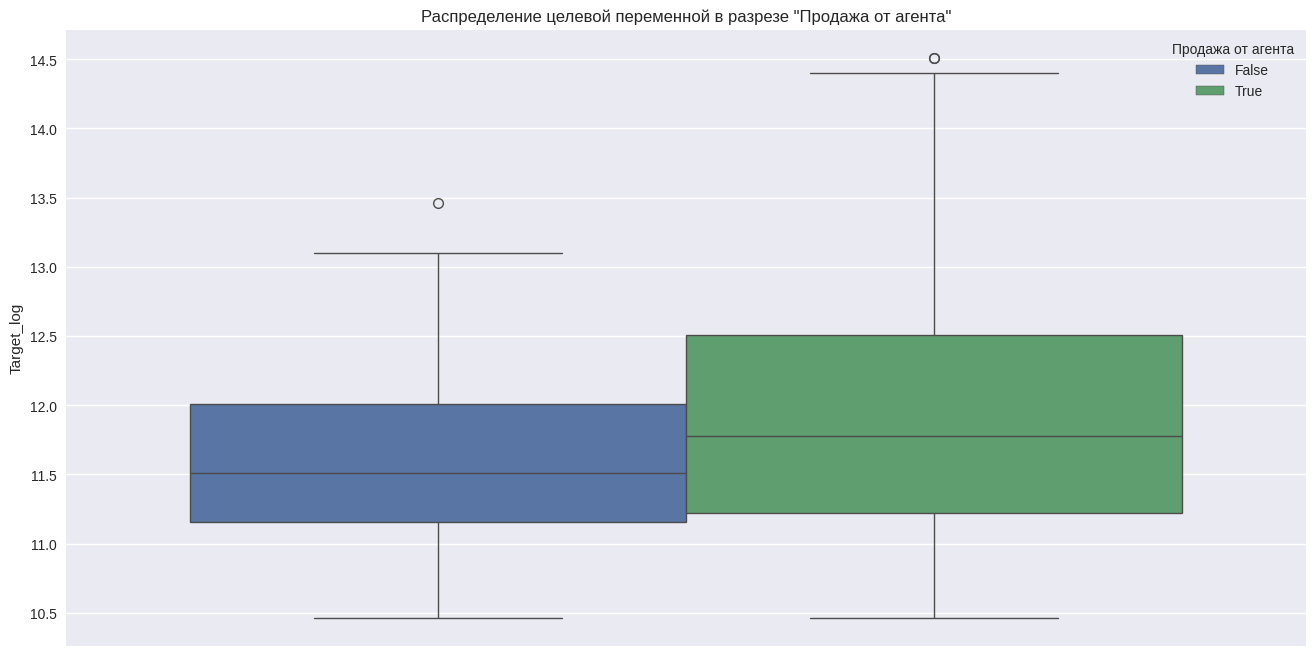

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Продажа от агента', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Продажа от агента"');

Квартиры от собственников немного дешевле, чем при продаже от агентов.

### **Кол-во грузовых и пассажирских лифтов**

Для начала создадим новый признак "Кол-во лифтов".

In [ ]:
data['Кол-во лифтов'] = data['Кол-во грузовых лифтов'] + data['Кол-во пассажирских лифтов']
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2
1,3,10,3,True,ЦАО,8.0,950000,True,0,1,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876,0,1
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6


Также создадим признак "Наличие грузового лифта".

In [ ]:
data['Наличие грузового лифта'] = data['Кол-во грузовых лифтов'].apply(lambda x: 0 if x == 0 else 1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
1,3,10,3,True,ЦАО,8.0,950000,True,0,1,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876,0,1,0
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6,1


Удаляем теперь ненужные признаки: "Кол-во грузовых лифтов" и "Кол-во пассажирских лифтов".

In [ ]:
data = data.drop(['Кол-во грузовых лифтов', 'Кол-во пассажирских лифтов'], axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,True,other,4.0,168800,True,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
1,3,10,3,True,ЦАО,8.0,950000,True,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876,0,1,0
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,True,ЦАО,3.0,400000,True,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,True,ЦАО,3.0,570000,True,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6,1


Теперь изучим вновь испеченные признаки, для начала посмотрим на признак "Кол-во лифтов".

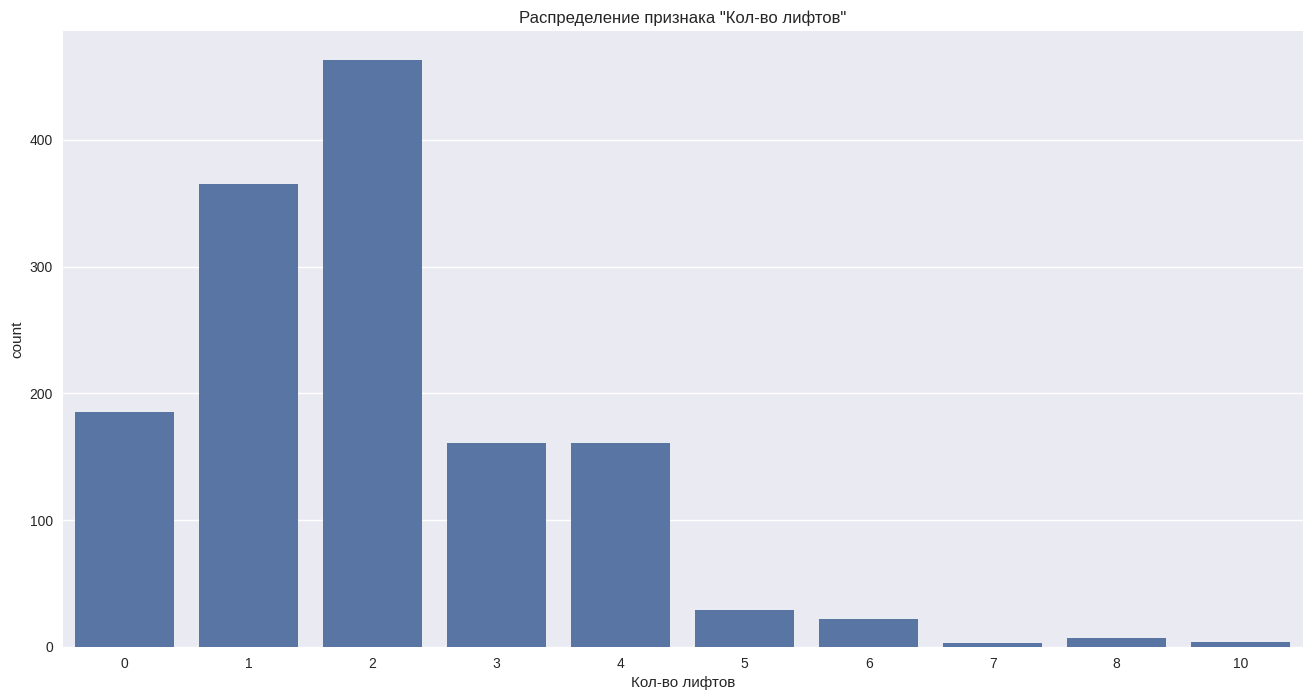

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во лифтов', ax=ax)
ax.set_title('Распределение признака "Кол-во лифтов"');

Таргет в разрезе этого признака:

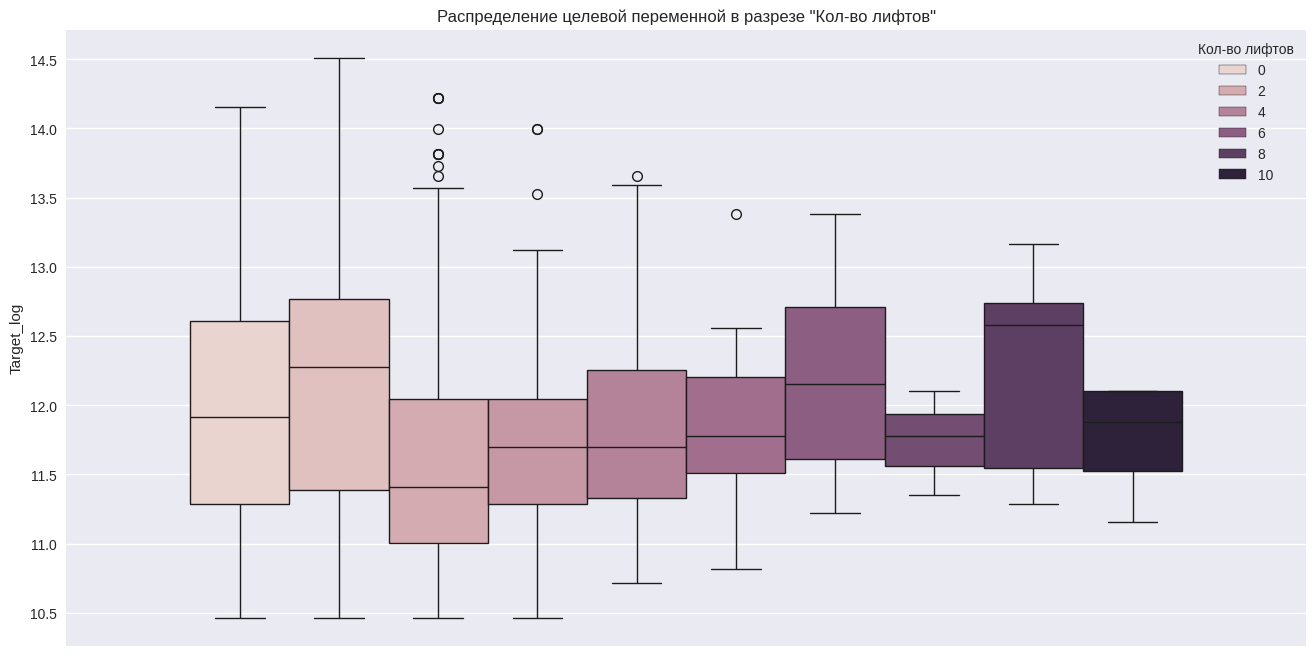

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Кол-во лифтов', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Кол-во лифтов"');

Суди из данной визуализации кол-во лифтов в доме не влияет на стоимость аренды на квартиры.

Посмотрим на факт наличия грузового лифта.

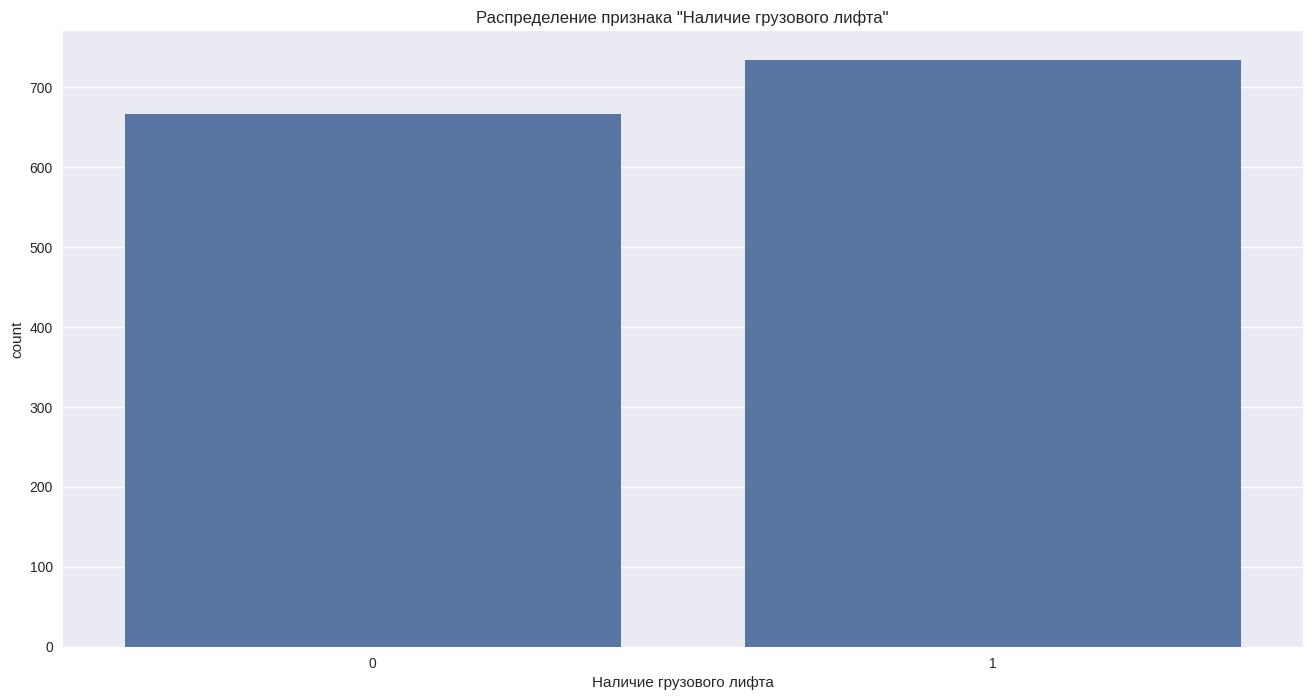

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие грузового лифта', ax=ax)
ax.set_title('Распределение признака "Наличие грузового лифта"');

Целевой признак в разрезе этого признака:

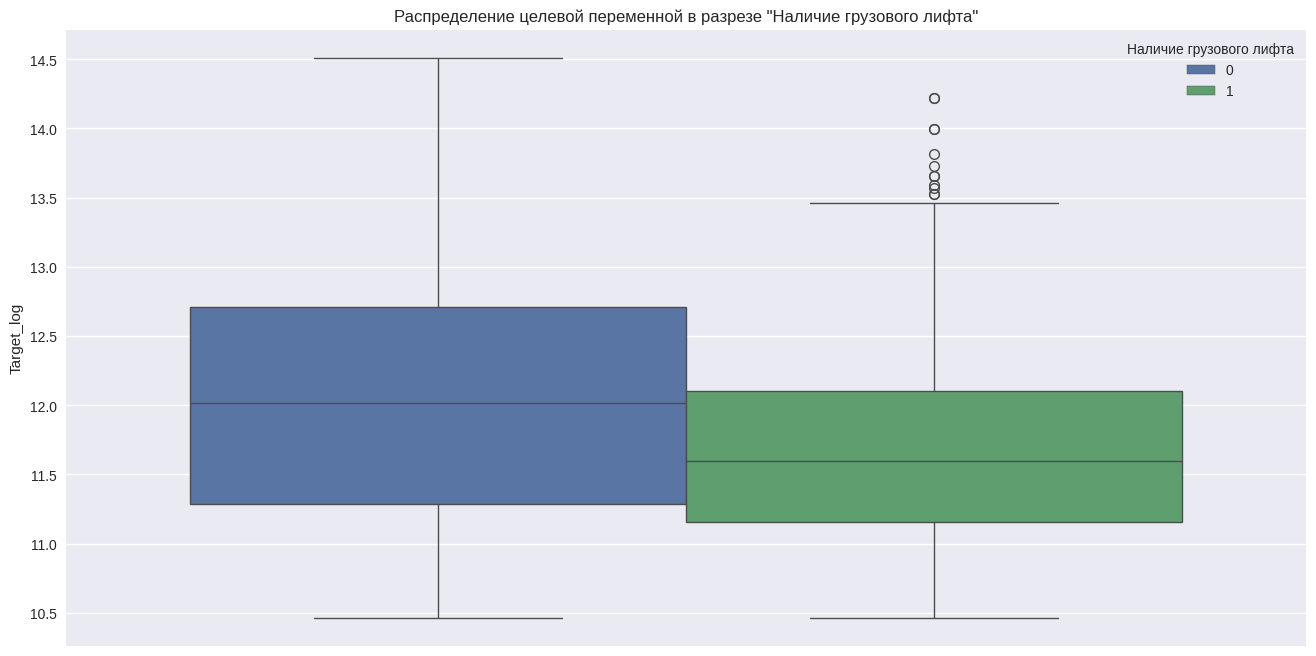

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Наличие грузового лифта', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие грузового лифта"');

Странно, но квартиры, которые находятся в домах с грузовыми лифтами стоят меньше.

### **Парковка**

Посмотрим на то, какие значения присутствуют в признаке:

In [ ]:
data['Парковка'].unique().tolist()

['underground', 'ground', 'open', 'multilevel']

Распределение признака:

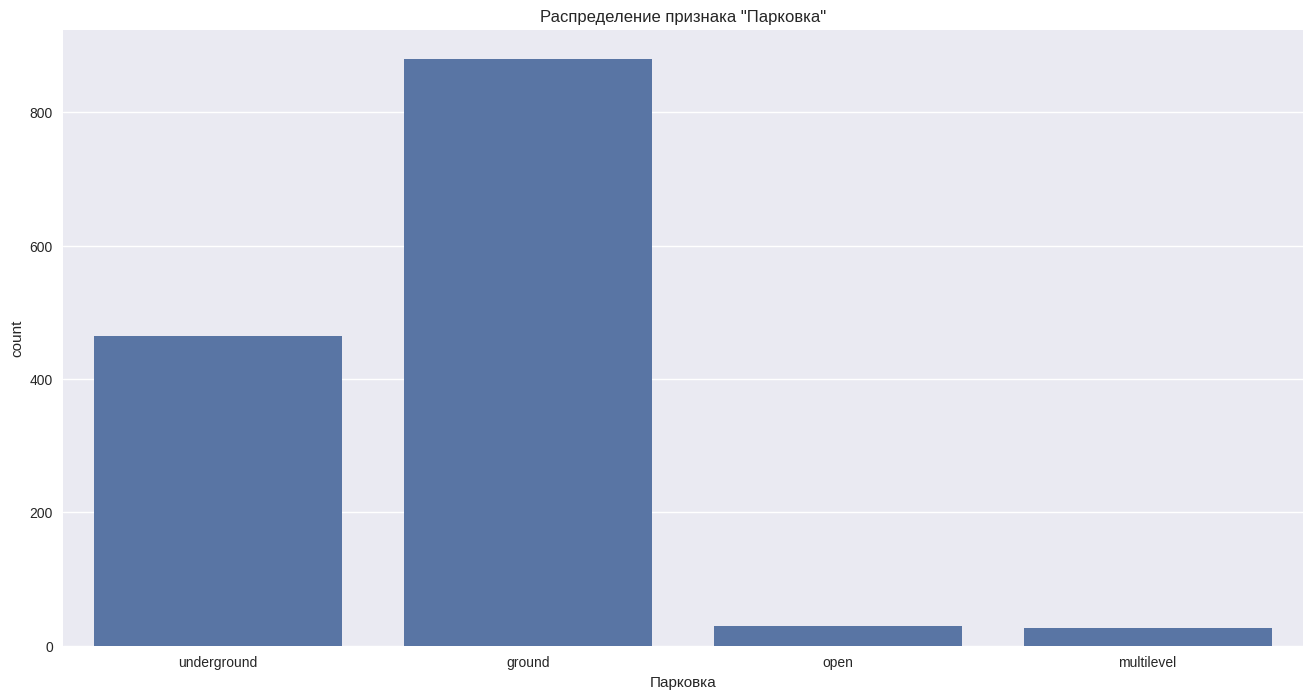

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Парковка', ax=ax)
ax.set_title('Распределение признака "Парковка"');

В данных очень мало наблюдений, которые относятся к классам open и multilevel, давайте объеденим их с классом ground.

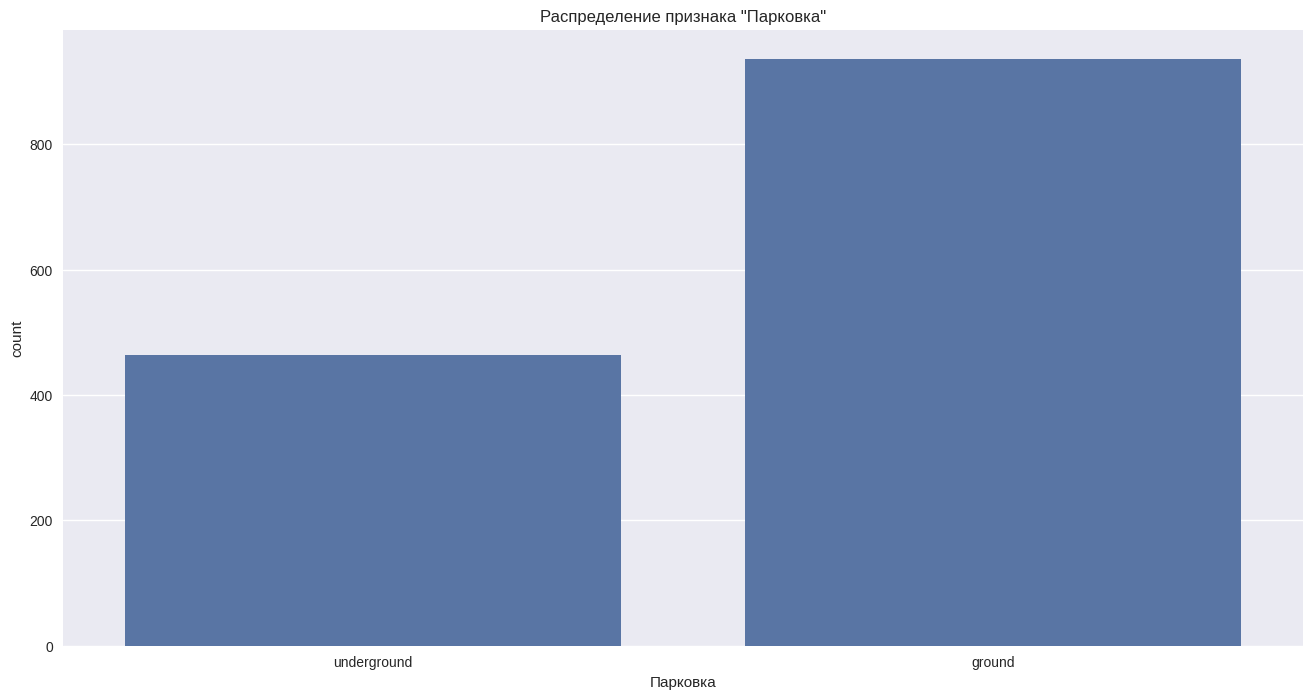

In [ ]:
data['Парковка'] = data['Парковка'].apply(lambda x: 'ground' if x == 'open' or x == 'multilevel' else x)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Парковка', ax=ax)
ax.set_title('Распределение признака "Парковка"');

Посмотрим на таргет относительно признака "Парковка":

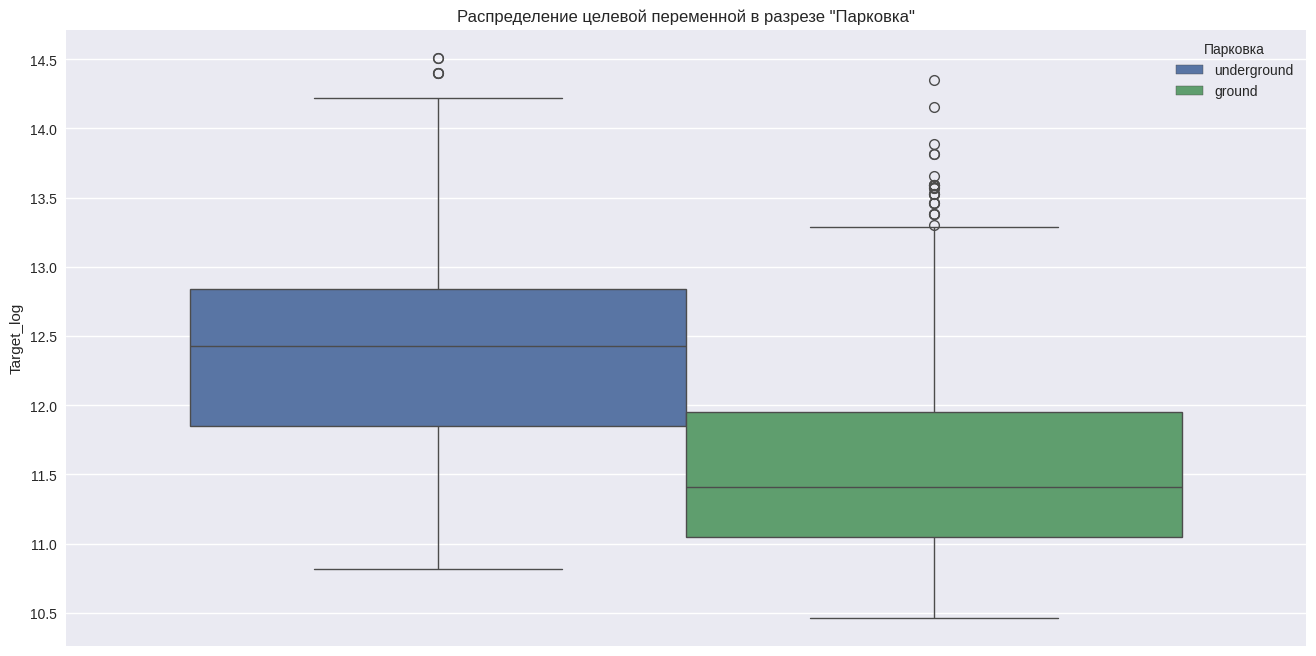

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Парковка', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Парковка"');

Итак, можно сделать вывод, что квартиры, которые находятся в домах с подземной парковкой сдают дороже, чем с наземной.

## Подготовка данных к обучению модели

Нам необходимо закодировать категориальные признаки и проверить данные на мультиколлинеарность, перед тем, как начать обучать модель. Также разобьем данные на тестовую и обучающую выборки.

Посмотрим еще раз на информацию о наших данных.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Этаж                     1400 non-null   int64  
 1   Кол-во этажей            1400 non-null   int64  
 2   Кол-во комнат            1400 non-null   int64  
 3   Наличие мебели           1400 non-null   bool   
 4   Округ                    1400 non-null   object 
 5   Ближайшее метро, мин.    1400 non-null   float64
 6   Стоимость, мес.          1400 non-null   int64  
 7   Продажа от агента        1400 non-null   bool   
 8   Парковка                 1400 non-null   object 
 9   Target_log               1400 non-null   float64
 10  Последний этаж           1400 non-null   float64
 11  Первый этаж              1400 non-null   float64
 12  Площадь_log              1400 non-null   float64
 13  Жилая_площадь_log        1400 non-null   float64
 14  Площадь_кухни_log        1400

Сначала закодируем признаки наличие мебели и продажа от агента:

In [ ]:
data['Наличие мебели'] = data['Наличие мебели'].apply(lambda x: 1 if x == True else 0)
data['Продажа от агента'] = data['Продажа от агента'].apply(lambda x: 1 if x == True else 0)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,1,other,4.0,168800,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
1,3,10,3,1,ЦАО,8.0,950000,1,underground,13.764218,0.0,0.0,5.159055,4.875197,3.218876,0,1,0
2,23,23,1,1,НАО (Новомосковский),2.0,60000,1,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,1,ЦАО,3.0,400000,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,1,ЦАО,3.0,570000,1,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6,1


Теперь закодируем признаки округа и парковки, для этого воспользуемся OneHotEncoding.

In [ ]:
#Выбираем категориальные признаки
cat_features = data.select_dtypes(include=['object']).columns
#Создаем экземпляр BinaryEncoder
encoder = ce.OneHotEncoder(cols=cat_features, use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data[cat_features])
data = pd.concat([data, type_bin], axis=1)

#Удаляем оригинальные категориальные признаки
data.drop(cat_features, axis=1, inplace=True)
print(f'Shape of data: {data.shape}')
data.head()

Shape of data: (1400, 23)


,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Target_log,Последний этаж,Первый этаж,...,Наличие балкона,Кол-во лифтов,Наличие грузового лифта,Округ_other,Округ_ЦАО,Округ_НАО (Новомосковский),Округ_ЗАО,Округ_САО,Парковка_underground,Парковка_ground
0,20,23,3,1,4.0,168800,1,12.036476,0.0,0.0,...,0,2,1,1,0,0,0,0,1,0
1,3,10,3,1,8.0,950000,1,13.764218,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0
2,23,23,1,1,2.0,60000,1,11.002117,1.0,0.0,...,0,3,0,0,0,1,0,0,0,1
3,8,10,3,1,3.0,400000,1,12.899222,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0
4,45,75,3,1,3.0,570000,1,13.253393,0.0,0.0,...,0,6,1,0,1,0,0,0,1,0


Чтобы проверить данные на мультиколлинеарность, посмотрим на матрицу корреляций.

<Axes: >

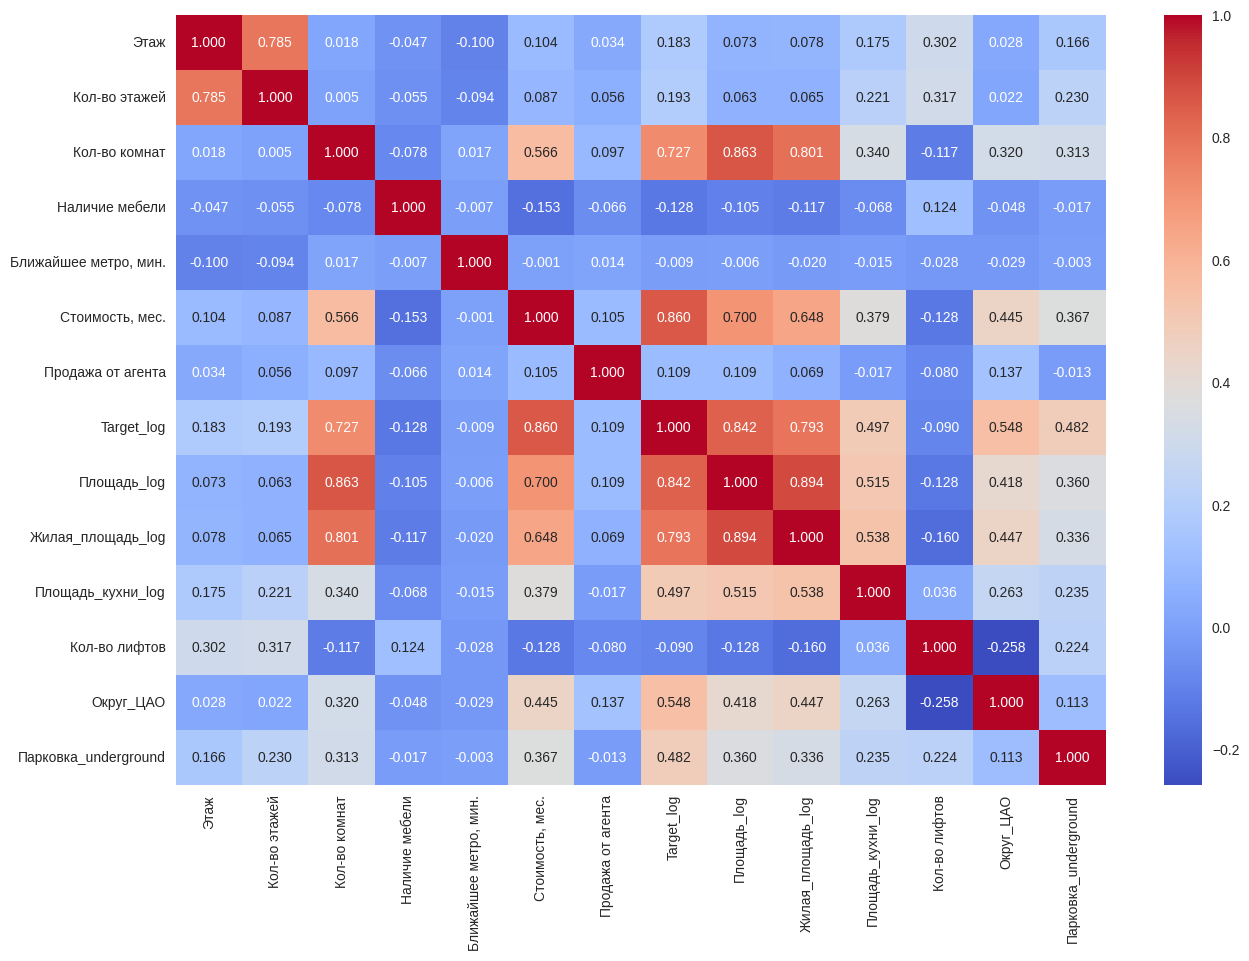

In [ ]:
result_columns = []
for column in data:
    col_data = data[column]
    if col_data.min() < -0.8 or col_data.sort_values(ascending=False)[1] > 0.8:
        result_columns.append(column)
        
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[result_columns].corr(), annot=True, cmap='coolwarm', fmt='.3f')

Разбиваем данные на тестовую и обучающую выборки.

In [ ]:
X = data.drop(['Стоимость, мес.', 'Target_log'], axis=1) #Матрица наблюдений
y = data['Target_log'] #Вектор правильных ответов

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (1120, 21)
Test shape: (280, 21)


Также данные необходимо отмасштабировать.

In [834]:
#Обучаем MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
#Нормализуем данные
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Ответы для метрик
y_train_for_metrics = np.exp(y_train) + 1
y_test_for_metrics  = np.exp(y_test) + 1

## Построение модели

В качестве метрик для оценки наших моделей будем использовать MAPE и MAE.

Для начала построим baseline в виде линейной регрессии, чтобы посмотреть решается ли наша задача и оценить можно ли ее решить простыми моделями.

In [835]:
#Обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
#Строим предсказания и выводим метрики
y_train_pred = np.exp(lr_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(lr_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train MAPE: 27.14
Test MAPE: 26.77
Train MAE: 67170.65
Test MAE: 50500.75


Модель дает давольно слабые результаты, посмотрим, как с этой задачей справится дерево решений.

In [837]:
#Модель
dt_model = DecisionTreeRegressor(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
}
#Подбор гиперпараметров
grid_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_grid,
    cv=5,
    n_iter=10,
    verbose=2,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train_scaled, y_train)
print(f'best params: {grid_dt.best_params_}')
dt_model = grid_dt.best_estimator_
#Строим предсказания и выводим метрики
y_train_pred = np.exp(lr_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(lr_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.